In [1]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from functions_v2 import(import_train_folder_dataset_2, 
                      Data_2, 
                      plot_loss_accuracy, 
                      accuracy_given_set,
                      import_test_folder_dataset_2,
                      Data_test_2,
                      make_predictions,
                      save_predictions_as_csv,
                      save_model,
                      save_metrics)

# 1. Build your own convolutional neural network using pytorch

In [4]:
# Learning parameters.
epochs = 500 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 1/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        
        '''
        In dimension:              224 * 224 * 3 
        Out dimension Conv:        224 * 224 * 16
        Out dimension MaxPooling:  112 * 112 * 16
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        )
        self.batch1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              112 * 112 * 16
        Out dimension Conv:        112 * 112 * 32
        Out dimension MaxPooling:  56  * 56  * 32
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        )
        self.batch2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              56  * 56  * 32
        Out dimension Conv:        56  * 56  * 64
        Out dimension MaxPooling:  28  * 28  * 64
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        )
        self.batch3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              28  * 28  * 64
        Out dimension Conv:        28  * 28  * 128
        Out dimension MaxPooling:  7  * 7  * 128
        '''
        self.cnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.batch4 = nn.BatchNorm2d(128)
        self.maxpool4 = nn.MaxPool2d(4, stride=4)
        
        
        
        self.ffnn_model = nn.Sequential(
            nn.Linear(in_features=6272, out_features=512),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=4)
        )
        
        
        
    def forward(self, x): 
        
        # Convolution
        x = self.cnn1_model(x)
        x = self.batch1(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool1(x)
        
        
        # Convolution
        x = self.cnn2_model(x)
        x = self.batch2(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool2(x)
        
        
        # Convolution
        x = self.cnn3_model(x)
        x = self.batch3(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool3(x)
        
        
        # Convolution
        x = self.cnn4_model(x)
        x = self.batch4(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool4(x)
        
        
        x = torch.flatten(x,start_dim=1)
        #print("Flatten Out: ",x.shape)
        x = self.ffnn_model(x)
        #print("ffnn out: ",x.shape)
        x = torch.sigmoid(x)
        #print("Sigmoid Out: ",x.shape)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = ClassificationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")
# Loss function.
criterion = nn.CrossEntropyLoss() # Set the loss function to cross entropy loss
# Optimizer.
optim = torch.optim.SGD(modelpy.parameters(), lr=lr)# , momentum=0.9, weight_decay=1e-3


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")


modelpy

model created


ClassificationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch3): BatchNorm2d(64

In [7]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 3711988


# Load Data

In [8]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [9]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((275, 275)),
                                    #transforms.CenterCrop((224, 224)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [10]:
# Import the data into a resized 224x224 images
size_of_resized_img = (224,224) 
train_data, train_labels = import_train_folder_dataset_2(train_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (1149, 224, 224, 3)
Dim of Lables:  (1149,)


In [11]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 224, 224, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 224, 224, 3)
Dim of y_test:  (115,)


In [12]:
# Create the dataset object
train_Dataset = Data_2(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data_2(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [13]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

In [14]:
print("Type of object: ",type(train_loader))

print()
print( 'Train Size: ' + str(len(train_loader)))
print( 'Validate Size: ' + str(len(valid_loader)))

print()
print("Content of one element: ",iter(train_loader).next())

print()
print("Type of one element: ", type(iter(train_loader).next()))
print("Length of one element: ", len(iter(train_loader).next()))

print()
print('Input tensors size: ' + str(iter(train_loader).next()[0].shape)) # Input: 16, 16875 | 16 train batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(train_loader).next()[1].shape)) # Label: 16 | 16 train Batch size


print()
print('Input tensors size: ' + str(iter(valid_loader).next()[0].shape)) # Input: 8, 16875 | 8 validation batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(valid_loader).next()[1].shape)) # Label: 8 | 8 validation Batch size


Type of object:  <class 'torch.utils.data.dataloader.DataLoader'>

Train Size: 65
Validate Size: 15

Content of one element:  [tensor([[[[-0.7650, -0.6794, -0.6109,  ...,  0.0569, -0.0629, -0.1486],
          [-0.7993, -0.6794, -0.6109,  ...,  0.2624,  0.1597,  0.0569],
          [-0.7822, -0.7137, -0.6965,  ...,  0.3994,  0.3481,  0.2967],
          ...,
          [-1.1932, -1.2445, -1.2959,  ..., -0.4054, -0.4397, -0.3541],
          [-1.1760, -1.2617, -1.2959,  ..., -0.4397, -0.4226, -0.4054],
          [-1.2274, -1.2617, -1.2445,  ..., -0.4739, -0.4054, -0.4911]],

         [[-0.6527, -0.5651, -0.5301,  ...,  0.2052,  0.1176,  0.0826],
          [-0.6877, -0.5476, -0.5126,  ...,  0.3102,  0.1877,  0.1527],
          [-0.6352, -0.5476, -0.5476,  ...,  0.3277,  0.2752,  0.2752],
          ...,
          [-0.8978, -0.9503, -1.0028,  ...,  0.1702,  0.1352,  0.2227],
          [-0.8803, -0.9678, -1.0028,  ...,  0.1352,  0.1527,  0.1702],
          [-0.9328, -0.9678, -0.9503,  ...,  0.10

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 


Epoch 1 of 500


100%|██████████| 15/15 [00:02<00:00,  7.07it/s]


train loss:  0.07305727729022618
Val loss:  0.14541353142779806
train accuracy:  0.5135396518375241
Val accuracy:  0.6173913043478261
Current time: 3.600 minutes. Time expected till completion: 1796.486 minutes

Epoch 2 of 500


100%|██████████| 15/15 [00:00<00:00, 19.95it/s]


train loss:  0.06991859192543841
Val loss:  0.1437571406364441
train accuracy:  0.5541586073500967
Val accuracy:  0.6434782608695652
Current time: 3.935 minutes. Time expected till completion: 979.849 minutes

Epoch 3 of 500


100%|██████████| 15/15 [00:00<00:00, 18.73it/s]


train loss:  0.06919562441929165
Val loss:  0.14555666032044784
train accuracy:  0.597678916827853
Val accuracy:  0.6347826086956522
Current time: 4.212 minutes. Time expected till completion: 697.772 minutes

Epoch 4 of 500


100%|██████████| 15/15 [00:00<00:00, 18.75it/s]


train loss:  0.0691448092114764
Val loss:  0.14206923298213792
train accuracy:  0.6092843326885881
Val accuracy:  0.6695652173913044
Current time: 4.494 minutes. Time expected till completion: 557.236 minutes

Epoch 5 of 500


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


train loss:  0.06867503082268012
Val loss:  0.1417554497718811
train accuracy:  0.6112185686653772
Val accuracy:  0.6347826086956522
Current time: 4.778 minutes. Time expected till completion: 473.037 minutes

Epoch 6 of 500


100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


train loss:  0.06779802958093713
Val loss:  0.14075089433918828
train accuracy:  0.6150870406189555
Val accuracy:  0.6521739130434783
Current time: 5.075 minutes. Time expected till completion: 417.805 minutes

Epoch 7 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.06803278189793777
Val loss:  0.14222190587416939
train accuracy:  0.6170212765957447
Val accuracy:  0.6347826086956522
Current time: 5.371 minutes. Time expected till completion: 378.240 minutes

Epoch 8 of 500


100%|██████████| 15/15 [00:00<00:00, 17.74it/s]


train loss:  0.06861759217841482
Val loss:  0.1412112443343453
train accuracy:  0.6131528046421664
Val accuracy:  0.6434782608695652
Current time: 5.664 minutes. Time expected till completion: 348.366 minutes

Epoch 9 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06791012066937047
Val loss:  0.1418409886567489
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 5.964 minutes. Time expected till completion: 325.347 minutes

Epoch 10 of 500


100%|██████████| 15/15 [00:00<00:00, 17.71it/s]


train loss:  0.06799279150464779
Val loss:  0.14054509504981663
train accuracy:  0.6112185686653772
Val accuracy:  0.6521739130434783
Current time: 6.254 minutes. Time expected till completion: 306.466 minutes

Epoch 11 of 500


100%|██████████| 15/15 [00:00<00:00, 18.71it/s]


train loss:  0.06789310417737905
Val loss:  0.15079200837923132
train accuracy:  0.6121856866537717
Val accuracy:  0.5478260869565217
Current time: 6.563 minutes. Time expected till completion: 291.733 minutes

Epoch 12 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06769980677553025
Val loss:  0.1426541779352271
train accuracy:  0.6034816247582205
Val accuracy:  0.6521739130434783
Current time: 6.856 minutes. Time expected till completion: 278.811 minutes

Epoch 13 of 500


100%|██████████| 15/15 [00:00<00:00, 18.48it/s]


train loss:  0.06805312829506466
Val loss:  0.1417629019073818
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 7.157 minutes. Time expected till completion: 268.119 minutes

Epoch 14 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06739890535057629
Val loss:  0.14179372372834578
train accuracy:  0.6121856866537717
Val accuracy:  0.6608695652173913
Current time: 7.450 minutes. Time expected till completion: 258.607 minutes

Epoch 15 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06733787982099522
Val loss:  0.14066119401351265
train accuracy:  0.625725338491296
Val accuracy:  0.6434782608695652
Current time: 7.742 minutes. Time expected till completion: 250.325 minutes

Epoch 16 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.06751703403212807
Val loss:  0.14038040845290475
train accuracy:  0.6150870406189555
Val accuracy:  0.6521739130434783
Current time: 8.037 minutes. Time expected till completion: 243.122 minutes

Epoch 17 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.06742687808706406
Val loss:  0.14019575222678807
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 8.331 minutes. Time expected till completion: 236.690 minutes

Epoch 18 of 500


100%|██████████| 15/15 [00:00<00:00, 18.64it/s]


train loss:  0.06737102034935868
Val loss:  0.13931928095610246
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 8.625 minutes. Time expected till completion: 230.952 minutes

Epoch 19 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.06721063791206773
Val loss:  0.14104053196699723
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 8.917 minutes. Time expected till completion: 225.752 minutes

Epoch 20 of 500


100%|██████████| 15/15 [00:00<00:00, 17.90it/s]


train loss:  0.06744400070299263
Val loss:  0.14137245053830355
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 9.211 minutes. Time expected till completion: 221.074 minutes

Epoch 21 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06717265078823156
Val loss:  0.14078436778939288
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 9.516 minutes. Time expected till completion: 217.062 minutes

Epoch 22 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06699614068295093
Val loss:  0.13845788136772488
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 9.813 minutes. Time expected till completion: 213.208 minutes

Epoch 23 of 500


100%|██████████| 15/15 [00:00<00:00, 18.68it/s]


train loss:  0.06707627889727255
Val loss:  0.14029429891835088
train accuracy:  0.6150870406189555
Val accuracy:  0.6608695652173913
Current time: 10.107 minutes. Time expected till completion: 209.600 minutes

Epoch 24 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.06760315369360682
Val loss:  0.14235781275707743
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 10.400 minutes. Time expected till completion: 206.260 minutes

Epoch 25 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.06710779240329676
Val loss:  0.13964256151862767
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 10.696 minutes. Time expected till completion: 203.231 minutes

Epoch 26 of 500


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


train loss:  0.06728423564069737
Val loss:  0.13910198159839796
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 10.998 minutes. Time expected till completion: 200.505 minutes

Epoch 27 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06699928612496912
Val loss:  0.1387849615967792
train accuracy:  0.6199226305609284
Val accuracy:  0.6695652173913044
Current time: 11.296 minutes. Time expected till completion: 197.884 minutes

Epoch 28 of 500


100%|██████████| 15/15 [00:00<00:00, 18.89it/s]


train loss:  0.06711424192561402
Val loss:  0.1396053241646808
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 11.592 minutes. Time expected till completion: 195.401 minutes

Epoch 29 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06678092122308521
Val loss:  0.13855454299760903
train accuracy:  0.6179883945841392
Val accuracy:  0.6695652173913044
Current time: 11.885 minutes. Time expected till completion: 193.033 minutes

Epoch 30 of 500


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


train loss:  0.06702292841684426
Val loss:  0.1384059491364852
train accuracy:  0.6170212765957447
Val accuracy:  0.6695652173913044
Current time: 12.187 minutes. Time expected till completion: 190.934 minutes

Epoch 31 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06754912479241997
Val loss:  0.14051812109739883
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 12.481 minutes. Time expected till completion: 188.819 minutes

Epoch 32 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.06704920553377104
Val loss:  0.13933765629063483
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 12.774 minutes. Time expected till completion: 186.817 minutes

Epoch 33 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.06649647402348324
Val loss:  0.1384492402491362
train accuracy:  0.6199226305609284
Val accuracy:  0.6695652173913044
Current time: 13.068 minutes. Time expected till completion: 184.929 minutes

Epoch 34 of 500


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


train loss:  0.06664179441315524
Val loss:  0.14515715267347254
train accuracy:  0.6199226305609284
Val accuracy:  0.6434782608695652
Current time: 13.363 minutes. Time expected till completion: 183.153 minutes

Epoch 35 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06695333359550461
Val loss:  0.13981270323628964
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 13.658 minutes. Time expected till completion: 181.453 minutes

Epoch 36 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.06689879891950803
Val loss:  0.1398524776748989
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 13.955 minutes. Time expected till completion: 179.862 minutes

Epoch 37 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06649566434568778
Val loss:  0.1396512798641039
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 14.253 minutes. Time expected till completion: 178.360 minutes

Epoch 38 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.06654154406986569
Val loss:  0.138243263700734
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 14.547 minutes. Time expected till completion: 176.861 minutes

Epoch 39 of 500


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


train loss:  0.06692565945868796
Val loss:  0.13805084073025248
train accuracy:  0.6179883945841392
Val accuracy:  0.6695652173913044
Current time: 14.841 minutes. Time expected till completion: 175.426 minutes

Epoch 40 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06637287762455599
Val loss:  0.13858234882354736
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 15.133 minutes. Time expected till completion: 174.032 minutes

Epoch 41 of 500


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]


train loss:  0.06662560673700772
Val loss:  0.137751915662185
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 15.431 minutes. Time expected till completion: 172.750 minutes

Epoch 42 of 500


100%|██████████| 15/15 [00:00<00:00, 18.48it/s]


train loss:  0.06645619788529564
Val loss:  0.13860005814096202
train accuracy:  0.6199226305609284
Val accuracy:  0.6695652173913044
Current time: 15.722 minutes. Time expected till completion: 171.450 minutes

Epoch 43 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.06648702080752449
Val loss:  0.13863671188769133
train accuracy:  0.6170212765957447
Val accuracy:  0.6695652173913044
Current time: 16.017 minutes. Time expected till completion: 170.232 minutes

Epoch 44 of 500


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


train loss:  0.06691211081565694
Val loss:  0.139044437719428
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 16.314 minutes. Time expected till completion: 169.070 minutes

Epoch 45 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06655874162393566
Val loss:  0.1408445156138876
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 16.610 minutes. Time expected till completion: 167.942 minutes

Epoch 46 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06654388162107486
Val loss:  0.1393427771070729
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 16.904 minutes. Time expected till completion: 166.831 minutes

Epoch 47 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06619420509273817
Val loss:  0.13815670479898867
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 17.200 minutes. Time expected till completion: 165.778 minutes

Epoch 48 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06608559926197193
Val loss:  0.13904381886772488
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 17.504 minutes. Time expected till completion: 164.829 minutes

Epoch 49 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.0663108740369402
Val loss:  0.138053151835566
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 17.802 minutes. Time expected till completion: 163.849 minutes

Epoch 50 of 500


100%|██████████| 15/15 [00:00<00:00, 18.71it/s]


train loss:  0.06633695164547668
Val loss:  0.13781774562338125
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 18.097 minutes. Time expected till completion: 162.874 minutes

Epoch 51 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.06608198522599108
Val loss:  0.13760480880737305
train accuracy:  0.620889748549323
Val accuracy:  0.6695652173913044
Current time: 18.393 minutes. Time expected till completion: 161.932 minutes

Epoch 52 of 500


100%|██████████| 15/15 [00:00<00:00, 18.25it/s]


train loss:  0.06593850658525581
Val loss:  0.137757842955382
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 18.689 minutes. Time expected till completion: 161.012 minutes

Epoch 53 of 500


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


train loss:  0.0660904682235976
Val loss:  0.13747455607289855
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 18.986 minutes. Time expected till completion: 160.123 minutes

Epoch 54 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.0655550691560343
Val loss:  0.1403105227843575
train accuracy:  0.632495164410058
Val accuracy:  0.6434782608695652
Current time: 19.279 minutes. Time expected till completion: 159.234 minutes

Epoch 55 of 500


100%|██████████| 15/15 [00:00<00:00, 17.80it/s]


train loss:  0.06583512549935272
Val loss:  0.13764885456665701
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 19.574 minutes. Time expected till completion: 158.373 minutes

Epoch 56 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.06559639529287238
Val loss:  0.13705935737361077
train accuracy:  0.6305609284332688
Val accuracy:  0.6695652173913044
Current time: 19.869 minutes. Time expected till completion: 157.536 minutes

Epoch 57 of 500


100%|██████████| 15/15 [00:00<00:00, 18.41it/s]


train loss:  0.06586818094410334
Val loss:  0.13639550157215286
train accuracy:  0.6266924564796905
Val accuracy:  0.6695652173913044
Current time: 20.163 minutes. Time expected till completion: 156.704 minutes

Epoch 58 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06566627240042622
Val loss:  0.14122293980225273
train accuracy:  0.6286266924564797
Val accuracy:  0.6782608695652174
Current time: 20.457 minutes. Time expected till completion: 155.894 minutes

Epoch 59 of 500


100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


train loss:  0.06594808558200269
Val loss:  0.1387730800587198
train accuracy:  0.6305609284332688
Val accuracy:  0.6695652173913044
Current time: 20.750 minutes. Time expected till completion: 155.097 minutes

Epoch 60 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06587113350687451
Val loss:  0.13973041980162912
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 21.044 minutes. Time expected till completion: 154.325 minutes

Epoch 61 of 500


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


train loss:  0.06569476203715548
Val loss:  0.1381594673446987
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 21.337 minutes. Time expected till completion: 153.553 minutes

Epoch 62 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.0656313363541948
Val loss:  0.13565719905106918
train accuracy:  0.6315280464216635
Val accuracy:  0.6695652173913044
Current time: 21.632 minutes. Time expected till completion: 152.816 minutes

Epoch 63 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06546036636806318
Val loss:  0.13658119595569113
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 21.926 minutes. Time expected till completion: 152.087 minutes

Epoch 64 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.06545145097738078
Val loss:  0.13645788638488107
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 22.219 minutes. Time expected till completion: 151.365 minutes

Epoch 65 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.06531121969453602
Val loss:  0.13697135137475056
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 22.512 minutes. Time expected till completion: 150.656 minutes

Epoch 66 of 500


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


train loss:  0.06566781116869279
Val loss:  0.1368298473565475
train accuracy:  0.6295938104448743
Val accuracy:  0.6695652173913044
Current time: 22.807 minutes. Time expected till completion: 149.973 minutes

Epoch 67 of 500


100%|██████████| 15/15 [00:00<00:00, 18.48it/s]


train loss:  0.06544175519242278
Val loss:  0.13767557455145796
train accuracy:  0.6431334622823984
Val accuracy:  0.6521739130434783
Current time: 23.101 minutes. Time expected till completion: 149.298 minutes

Epoch 68 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06507984455134468
Val loss:  0.13863732140997181
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 23.393 minutes. Time expected till completion: 148.614 minutes

Epoch 69 of 500


100%|██████████| 15/15 [00:00<00:00, 18.43it/s]


train loss:  0.06486516245559751
Val loss:  0.13937035902686742
train accuracy:  0.6411992263056093
Val accuracy:  0.6608695652173913
Current time: 23.684 minutes. Time expected till completion: 147.942 minutes

Epoch 70 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.06505132119245179
Val loss:  0.1396719533464183
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Current time: 23.981 minutes. Time expected till completion: 147.311 minutes

Epoch 71 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.06491764175130967
Val loss:  0.13680327353270158
train accuracy:  0.6450676982591876
Val accuracy:  0.6434782608695652
Current time: 24.276 minutes. Time expected till completion: 146.684 minutes

Epoch 72 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.06501654972190783
Val loss:  0.13837876786356387
train accuracy:  0.6266924564796905
Val accuracy:  0.6347826086956522
Current time: 24.574 minutes. Time expected till completion: 146.078 minutes

Epoch 73 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.06527236749632447
Val loss:  0.1371649830237679
train accuracy:  0.6411992263056093
Val accuracy:  0.6521739130434783
Current time: 24.868 minutes. Time expected till completion: 145.461 minutes

Epoch 74 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.06463885572477743
Val loss:  0.1355109453201294
train accuracy:  0.6363636363636364
Val accuracy:  0.6695652173913044
Current time: 25.163 minutes. Time expected till completion: 144.854 minutes

Epoch 75 of 500


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


train loss:  0.06533410453473576
Val loss:  0.1350688099861145
train accuracy:  0.6305609284332688
Val accuracy:  0.6260869565217392
Current time: 25.456 minutes. Time expected till completion: 144.251 minutes

Epoch 76 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.06523711705576751
Val loss:  0.13479824428972992
train accuracy:  0.6382978723404256
Val accuracy:  0.6782608695652174
Current time: 25.751 minutes. Time expected till completion: 143.662 minutes

Epoch 77 of 500


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


train loss:  0.06535817184116209
Val loss:  0.13697550089462943
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 26.047 minutes. Time expected till completion: 143.088 minutes

Epoch 78 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06471547622745226
Val loss:  0.13594957693763401
train accuracy:  0.6411992263056093
Val accuracy:  0.6695652173913044
Current time: 26.340 minutes. Time expected till completion: 142.506 minutes

Epoch 79 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.06494839815152682
Val loss:  0.13438073500342992
train accuracy:  0.6537717601547389
Val accuracy:  0.6869565217391305
Current time: 26.634 minutes. Time expected till completion: 141.936 minutes

Epoch 80 of 500


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


train loss:  0.06518340093485392
Val loss:  0.13711358827093373
train accuracy:  0.6528046421663443
Val accuracy:  0.6869565217391305
Current time: 26.926 minutes. Time expected till completion: 141.363 minutes

Epoch 81 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.06466873534874021
Val loss:  0.13330917928529823
train accuracy:  0.6508704061895552
Val accuracy:  0.6434782608695652
Current time: 27.220 minutes. Time expected till completion: 140.807 minutes

Epoch 82 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06476046614766813
Val loss:  0.13418478395627892
train accuracy:  0.6421663442940039
Val accuracy:  0.6695652173913044
Current time: 27.514 minutes. Time expected till completion: 140.252 minutes

Epoch 83 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.0649584317922131
Val loss:  0.13531476051911065
train accuracy:  0.6479690522243714
Val accuracy:  0.6869565217391305
Current time: 27.808 minutes. Time expected till completion: 139.710 minutes

Epoch 84 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.06507706463452234
Val loss:  0.13658002200333969
train accuracy:  0.6392649903288201
Val accuracy:  0.6869565217391305
Current time: 28.102 minutes. Time expected till completion: 139.173 minutes

Epoch 85 of 500


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


train loss:  0.06445868627476277
Val loss:  0.13487934288771256
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 28.395 minutes. Time expected till completion: 138.632 minutes

Epoch 86 of 500


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


train loss:  0.06445836876762213
Val loss:  0.13683243419813074
train accuracy:  0.6499032882011605
Val accuracy:  0.6347826086956522
Current time: 28.688 minutes. Time expected till completion: 138.105 minutes

Epoch 87 of 500


100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


train loss:  0.06442742444560422
Val loss:  0.13586283507554428
train accuracy:  0.6470019342359767
Val accuracy:  0.6869565217391305
Current time: 28.983 minutes. Time expected till completion: 137.584 minutes

Epoch 88 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.06468342357032304
Val loss:  0.1354150020557901
train accuracy:  0.6382978723404256
Val accuracy:  0.6782608695652174
Current time: 29.275 minutes. Time expected till completion: 137.061 minutes

Epoch 89 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06507172938472297
Val loss:  0.13582113618436067
train accuracy:  0.6470019342359767
Val accuracy:  0.6347826086956522
Current time: 29.572 minutes. Time expected till completion: 136.561 minutes

Epoch 90 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.06443801591428613
Val loss:  0.13767663499583369
train accuracy:  0.6441005802707931
Val accuracy:  0.6434782608695652
Current time: 29.866 minutes. Time expected till completion: 136.054 minutes

Epoch 91 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06426790731326755
Val loss:  0.13726518931596177
train accuracy:  0.648936170212766
Val accuracy:  0.6608695652173913
Current time: 30.165 minutes. Time expected till completion: 135.576 minutes

Epoch 92 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.0643121946019407
Val loss:  0.13554490338201108
train accuracy:  0.6673114119922631
Val accuracy:  0.6347826086956522
Current time: 30.457 minutes. Time expected till completion: 135.071 minutes

Epoch 93 of 500


100%|██████████| 15/15 [00:00<00:00, 18.43it/s]


train loss:  0.06407157105449551
Val loss:  0.13715506014616594
train accuracy:  0.6421663442940039
Val accuracy:  0.6956521739130435
Current time: 30.752 minutes. Time expected till completion: 134.582 minutes

Epoch 94 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.06429952296574296
Val loss:  0.13626268791115803
train accuracy:  0.6547388781431335
Val accuracy:  0.6695652173913044
Current time: 31.045 minutes. Time expected till completion: 134.086 minutes

Epoch 95 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06421080761998027
Val loss:  0.14051137385161028
train accuracy:  0.6431334622823984
Val accuracy:  0.6347826086956522
Current time: 31.341 minutes. Time expected till completion: 133.610 minutes

Epoch 96 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.06435454053159378
Val loss:  0.13495354911555416
train accuracy:  0.6508704061895552
Val accuracy:  0.6782608695652174
Current time: 31.634 minutes. Time expected till completion: 133.127 minutes

Epoch 97 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06407311552958977
Val loss:  0.13823679789252905
train accuracy:  0.6537717601547389
Val accuracy:  0.6608695652173913
Current time: 31.928 minutes. Time expected till completion: 132.651 minutes

Epoch 98 of 500


100%|██████████| 15/15 [00:00<00:00, 18.64it/s]


train loss:  0.06441475113770948
Val loss:  0.13629638215769893
train accuracy:  0.6566731141199227
Val accuracy:  0.6521739130434783
Current time: 32.221 minutes. Time expected till completion: 132.173 minutes

Epoch 99 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06374020963849597
Val loss:  0.13567896511243738
train accuracy:  0.6663442940038685
Val accuracy:  0.6608695652173913
Current time: 32.515 minutes. Time expected till completion: 131.701 minutes

Epoch 100 of 500


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


train loss:  0.06412684663813165
Val loss:  0.13637051115865292
train accuracy:  0.6441005802707931
Val accuracy:  0.6521739130434783
Saving model checkpoint


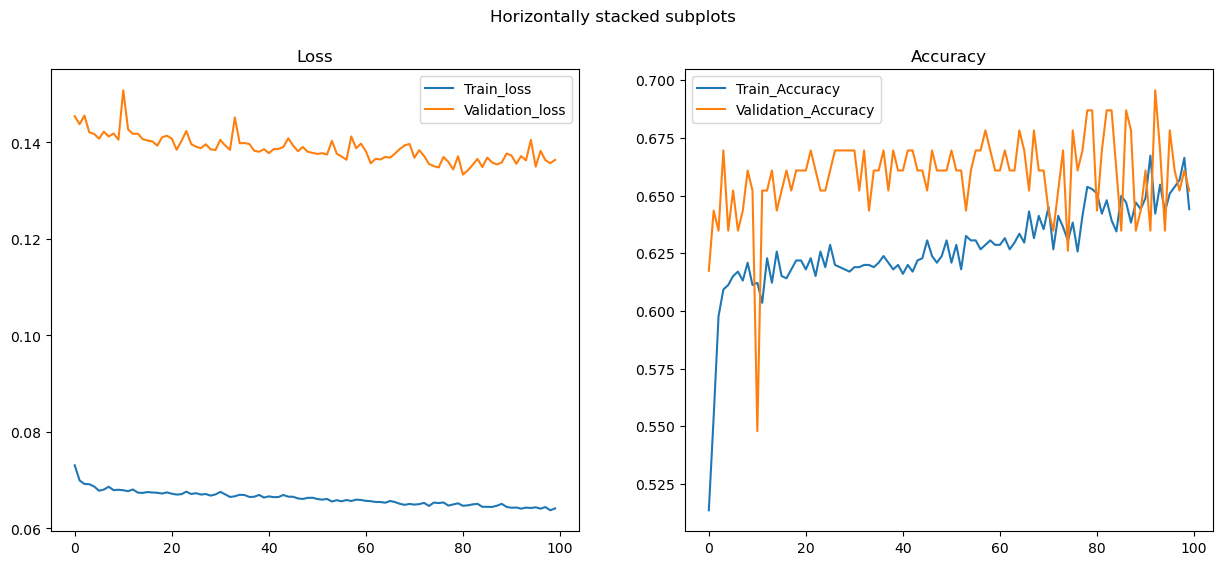

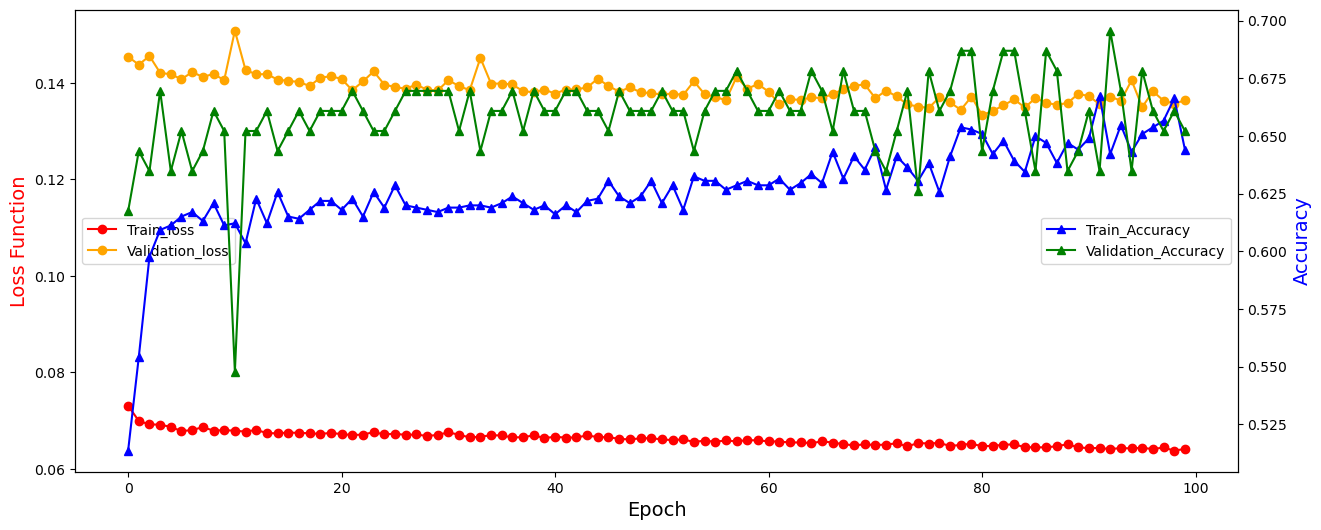

Current time: 32.984 minutes. Time expected till completion: 131.936 minutes

Epoch 101 of 500


100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


train loss:  0.06425522051650735
Val loss:  0.13918723023456075
train accuracy:  0.6576402321083172
Val accuracy:  0.6608695652173913
Current time: 33.279 minutes. Time expected till completion: 131.467 minutes

Epoch 102 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06405429902344192
Val loss:  0.13682512355887372
train accuracy:  0.655705996131528
Val accuracy:  0.6347826086956522
Current time: 33.572 minutes. Time expected till completion: 130.997 minutes

Epoch 103 of 500


100%|██████████| 15/15 [00:00<00:00, 16.79it/s]


train loss:  0.06407951778323323
Val loss:  0.13302202846692956
train accuracy:  0.6615087040618955
Val accuracy:  0.6434782608695652
Current time: 33.867 minutes. Time expected till completion: 130.535 minutes

Epoch 104 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.06378486764039015
Val loss:  0.13595902712448785
train accuracy:  0.6682785299806576
Val accuracy:  0.6695652173913044
Current time: 34.161 minutes. Time expected till completion: 130.074 minutes

Epoch 105 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06373798835669542
Val loss:  0.1368524380352186
train accuracy:  0.6663442940038685
Val accuracy:  0.6521739130434783
Current time: 34.454 minutes. Time expected till completion: 129.612 minutes

Epoch 106 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.0637076554722666
Val loss:  0.13697885274887084
train accuracy:  0.6595744680851063
Val accuracy:  0.6260869565217392
Current time: 34.747 minutes. Time expected till completion: 129.155 minutes

Epoch 107 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.06406266955619162
Val loss:  0.13786869930184406
train accuracy:  0.6595744680851063
Val accuracy:  0.6086956521739131
Current time: 35.044 minutes. Time expected till completion: 128.712 minutes

Epoch 108 of 500


100%|██████████| 15/15 [00:00<00:00, 18.68it/s]


train loss:  0.06403834198383575
Val loss:  0.13526405666185462
train accuracy:  0.6528046421663443
Val accuracy:  0.6695652173913044
Current time: 35.340 minutes. Time expected till completion: 128.272 minutes

Epoch 109 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.0640138359434139
Val loss:  0.13625464387561964
train accuracy:  0.6547388781431335
Val accuracy:  0.6521739130434783
Current time: 35.633 minutes. Time expected till completion: 127.821 minutes

Epoch 110 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06367495552252986
Val loss:  0.1378057775290116
train accuracy:  0.6634429400386848
Val accuracy:  0.6608695652173913
Current time: 35.928 minutes. Time expected till completion: 127.382 minutes

Epoch 111 of 500


100%|██████████| 15/15 [00:00<00:00, 18.01it/s]


train loss:  0.06396951527844545
Val loss:  0.1347056850143101
train accuracy:  0.6595744680851063
Val accuracy:  0.6521739130434783
Current time: 36.220 minutes. Time expected till completion: 126.932 minutes

Epoch 112 of 500


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


train loss:  0.06402880420306666
Val loss:  0.13606727641561758
train accuracy:  0.6615087040618955
Val accuracy:  0.6608695652173913
Current time: 36.513 minutes. Time expected till completion: 126.492 minutes

Epoch 113 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.06353658068802648
Val loss:  0.13447421892829564
train accuracy:  0.6644100580270793
Val accuracy:  0.6695652173913044
Current time: 36.808 minutes. Time expected till completion: 126.059 minutes

Epoch 114 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.06361429799686778
Val loss:  0.13899037889812305
train accuracy:  0.6566731141199227
Val accuracy:  0.6260869565217392
Current time: 37.102 minutes. Time expected till completion: 125.625 minutes

Epoch 115 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.06362957719216264
Val loss:  0.13538527281387994
train accuracy:  0.6634429400386848
Val accuracy:  0.6695652173913044
Current time: 37.398 minutes. Time expected till completion: 125.202 minutes

Epoch 116 of 500


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


train loss:  0.06322209868486431
Val loss:  0.1365237946095674
train accuracy:  0.6818181818181818
Val accuracy:  0.6521739130434783
Current time: 37.692 minutes. Time expected till completion: 124.772 minutes

Epoch 117 of 500


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


train loss:  0.06363841781763782
Val loss:  0.13977104321770045
train accuracy:  0.6760154738878144
Val accuracy:  0.6260869565217392
Current time: 37.986 minutes. Time expected till completion: 124.346 minutes

Epoch 118 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.06312767345623997
Val loss:  0.13929376291192097
train accuracy:  0.6750483558994197
Val accuracy:  0.6521739130434783
Current time: 38.280 minutes. Time expected till completion: 123.924 minutes

Epoch 119 of 500


100%|██████████| 15/15 [00:00<00:00, 17.80it/s]


train loss:  0.06355963223676847
Val loss:  0.13323364776113758
train accuracy:  0.6634429400386848
Val accuracy:  0.6695652173913044
Current time: 38.577 minutes. Time expected till completion: 123.511 minutes

Epoch 120 of 500


100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


train loss:  0.06386714626096435
Val loss:  0.13845313683800076
train accuracy:  0.660541586073501
Val accuracy:  0.6434782608695652
Current time: 38.868 minutes. Time expected till completion: 123.081 minutes

Epoch 121 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.0634536634791981
Val loss:  0.13748887932818868
train accuracy:  0.6576402321083172
Val accuracy:  0.6782608695652174
Current time: 39.162 minutes. Time expected till completion: 122.664 minutes

Epoch 122 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.06331260879911353
Val loss:  0.1350348799125008
train accuracy:  0.6518375241779497
Val accuracy:  0.6434782608695652
Current time: 39.460 minutes. Time expected till completion: 122.262 minutes

Epoch 123 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06325065005909312
Val loss:  0.13564205532488616
train accuracy:  0.6653771760154739
Val accuracy:  0.6695652173913044
Current time: 39.752 minutes. Time expected till completion: 121.841 minutes

Epoch 124 of 500


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


train loss:  0.06329828287462201
Val loss:  0.1369424643723861
train accuracy:  0.6827852998065764
Val accuracy:  0.6347826086956522
Current time: 40.043 minutes. Time expected till completion: 121.422 minutes

Epoch 125 of 500


100%|██████████| 15/15 [00:00<00:00, 18.57it/s]


train loss:  0.06313830804317555
Val loss:  0.1387430823367575
train accuracy:  0.6711798839458414
Val accuracy:  0.6521739130434783
Current time: 40.335 minutes. Time expected till completion: 121.006 minutes

Epoch 126 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.06323868958585728
Val loss:  0.13349288183709848
train accuracy:  0.6740812379110251
Val accuracy:  0.6869565217391305
Current time: 40.629 minutes. Time expected till completion: 120.597 minutes

Epoch 127 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.06344888605739439
Val loss:  0.13707299387973287
train accuracy:  0.6653771760154739
Val accuracy:  0.6695652173913044
Current time: 40.963 minutes. Time expected till completion: 120.307 minutes

Epoch 128 of 500


100%|██████████| 15/15 [00:00<00:00, 17.10it/s]


train loss:  0.06309149764492618
Val loss:  0.13246008831521738
train accuracy:  0.6847195357833655
Val accuracy:  0.6347826086956522
Current time: 41.293 minutes. Time expected till completion: 120.008 minutes

Epoch 129 of 500


100%|██████████| 15/15 [00:00<00:00, 16.97it/s]


train loss:  0.06272159058535814
Val loss:  0.13377051508944968
train accuracy:  0.6808510638297872
Val accuracy:  0.6695652173913044
Current time: 41.626 minutes. Time expected till completion: 119.715 minutes

Epoch 130 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06326535568938264
Val loss:  0.13468553708947223
train accuracy:  0.6808510638297872
Val accuracy:  0.6521739130434783
Current time: 41.950 minutes. Time expected till completion: 119.396 minutes

Epoch 131 of 500


100%|██████████| 15/15 [00:00<00:00, 17.71it/s]


train loss:  0.06302937876786208
Val loss:  0.1374206921328669
train accuracy:  0.6750483558994197
Val accuracy:  0.6434782608695652
Current time: 42.265 minutes. Time expected till completion: 119.052 minutes

Epoch 132 of 500


100%|██████████| 15/15 [00:00<00:00, 16.11it/s]


train loss:  0.06314351359234557
Val loss:  0.134564311089723
train accuracy:  0.6808510638297872
Val accuracy:  0.6608695652173913
Current time: 42.588 minutes. Time expected till completion: 118.731 minutes

Epoch 133 of 500


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


train loss:  0.06290618617022753
Val loss:  0.13753076895423558
train accuracy:  0.6808510638297872
Val accuracy:  0.6434782608695652
Current time: 42.895 minutes. Time expected till completion: 118.364 minutes

Epoch 134 of 500


100%|██████████| 15/15 [00:00<00:00, 17.62it/s]


train loss:  0.06311996641426529
Val loss:  0.13597890967908113
train accuracy:  0.6808510638297872
Val accuracy:  0.6695652173913044
Current time: 43.216 minutes. Time expected till completion: 118.037 minutes

Epoch 135 of 500


100%|██████████| 15/15 [00:00<00:00, 16.95it/s]


train loss:  0.06280049451084617
Val loss:  0.13665452469950137
train accuracy:  0.6711798839458414
Val accuracy:  0.6608695652173913
Current time: 43.541 minutes. Time expected till completion: 117.723 minutes

Epoch 136 of 500


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


train loss:  0.06282099643343883
Val loss:  0.1356785712034806
train accuracy:  0.6798839458413927
Val accuracy:  0.6347826086956522
Current time: 43.858 minutes. Time expected till completion: 117.383 minutes

Epoch 137 of 500


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


train loss:  0.06339305892903754
Val loss:  0.1388581307038017
train accuracy:  0.6653771760154739
Val accuracy:  0.6521739130434783
Current time: 44.170 minutes. Time expected till completion: 117.034 minutes

Epoch 138 of 500


100%|██████████| 15/15 [00:00<00:00, 16.23it/s]


train loss:  0.06284459041903512
Val loss:  0.13607317416564277
train accuracy:  0.6760154738878144
Val accuracy:  0.6608695652173913
Current time: 44.495 minutes. Time expected till completion: 116.719 minutes

Epoch 139 of 500


100%|██████████| 15/15 [00:00<00:00, 15.08it/s]


train loss:  0.06345104640872151
Val loss:  0.13720601434293
train accuracy:  0.6692456479690522
Val accuracy:  0.6
Current time: 44.807 minutes. Time expected till completion: 116.370 minutes

Epoch 140 of 500


100%|██████████| 15/15 [00:00<00:00, 15.38it/s]


train loss:  0.06324398079508739
Val loss:  0.13745259979496832
train accuracy:  0.6711798839458414
Val accuracy:  0.6086956521739131
Current time: 45.124 minutes. Time expected till completion: 116.034 minutes

Epoch 141 of 500


100%|██████████| 15/15 [00:00<00:00, 16.57it/s]


train loss:  0.06235257701901449
Val loss:  0.13566633825716765
train accuracy:  0.6876208897485493
Val accuracy:  0.6695652173913044
Current time: 45.435 minutes. Time expected till completion: 115.681 minutes

Epoch 142 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06241909562964965
Val loss:  0.13723868079807447
train accuracy:  0.6731141199226306
Val accuracy:  0.6347826086956522
Current time: 45.773 minutes. Time expected till completion: 115.399 minutes

Epoch 143 of 500


100%|██████████| 15/15 [00:02<00:00,  6.90it/s]


train loss:  0.062379352474581574
Val loss:  0.13830933726352193
train accuracy:  0.683752417794971
Val accuracy:  0.6434782608695652
Current time: 46.150 minutes. Time expected till completion: 115.213 minutes

Epoch 144 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06329452657146195
Val loss:  0.13976558084073273
train accuracy:  0.6827852998065764
Val accuracy:  0.6260869565217392
Current time: 46.589 minutes. Time expected till completion: 115.179 minutes

Epoch 145 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.06266040065302378
Val loss:  0.13805437969124834
train accuracy:  0.6663442940038685
Val accuracy:  0.6434782608695652
Current time: 46.892 minutes. Time expected till completion: 114.805 minutes

Epoch 146 of 500


100%|██████████| 15/15 [00:00<00:00, 18.68it/s]


train loss:  0.06299790503669754
Val loss:  0.13771069671796715
train accuracy:  0.6644100580270793
Val accuracy:  0.6521739130434783
Current time: 47.188 minutes. Time expected till completion: 114.416 minutes

Epoch 147 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.06262813557508605
Val loss:  0.13707972246667613
train accuracy:  0.695357833655706
Val accuracy:  0.6521739130434783
Current time: 47.500 minutes. Time expected till completion: 114.064 minutes

Epoch 148 of 500


100%|██████████| 15/15 [00:00<00:00, 17.95it/s]


train loss:  0.06301321426489367
Val loss:  0.13815120095792024
train accuracy:  0.6731141199226306
Val accuracy:  0.6173913043478261
Current time: 47.796 minutes. Time expected till completion: 113.677 minutes

Epoch 149 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.06310590963299086
Val loss:  0.14194247204324473
train accuracy:  0.6798839458413927
Val accuracy:  0.6173913043478261
Current time: 48.106 minutes. Time expected till completion: 113.325 minutes

Epoch 150 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.06269951150311262
Val loss:  0.137574505287668
train accuracy:  0.6924564796905223
Val accuracy:  0.6695652173913044
Current time: 48.415 minutes. Time expected till completion: 112.968 minutes

Epoch 151 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.0625979126191462
Val loss:  0.13786641566649727
train accuracy:  0.6779497098646035
Val accuracy:  0.6347826086956522
Current time: 48.729 minutes. Time expected till completion: 112.625 minutes

Epoch 152 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06256026415806444
Val loss:  0.13962680412375408
train accuracy:  0.6982591876208898
Val accuracy:  0.5826086956521739
Current time: 49.041 minutes. Time expected till completion: 112.278 minutes

Epoch 153 of 500


100%|██████████| 15/15 [00:00<00:00, 16.79it/s]


train loss:  0.06254360955965127
Val loss:  0.1361712388370348
train accuracy:  0.6769825918762089
Val accuracy:  0.6869565217391305
Current time: 49.341 minutes. Time expected till completion: 111.905 minutes

Epoch 154 of 500


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


train loss:  0.06243267280681913
Val loss:  0.1379269154175468
train accuracy:  0.695357833655706
Val accuracy:  0.6434782608695652
Current time: 49.654 minutes. Time expected till completion: 111.561 minutes

Epoch 155 of 500


100%|██████████| 15/15 [00:00<00:00, 15.13it/s]


train loss:  0.06222440189964767
Val loss:  0.14221495545428733
train accuracy:  0.6866537717601547
Val accuracy:  0.6260869565217392
Current time: 49.983 minutes. Time expected till completion: 111.252 minutes

Epoch 156 of 500


100%|██████████| 15/15 [00:00<00:00, 15.81it/s]


train loss:  0.06274061858999891
Val loss:  0.13631502804548845
train accuracy:  0.6798839458413927
Val accuracy:  0.6434782608695652
Current time: 50.351 minutes. Time expected till completion: 111.031 minutes

Epoch 157 of 500


100%|██████████| 15/15 [00:00<00:00, 15.59it/s]


train loss:  0.061851528154351035
Val loss:  0.13494899221088574
train accuracy:  0.6876208897485493
Val accuracy:  0.6782608695652174
Current time: 50.689 minutes. Time expected till completion: 110.741 minutes

Epoch 158 of 500


100%|██████████| 15/15 [00:00<00:00, 17.12it/s]


train loss:  0.06265463652647671
Val loss:  0.14181378820668097
train accuracy:  0.6914893617021277
Val accuracy:  0.5826086956521739
Current time: 51.025 minutes. Time expected till completion: 110.447 minutes

Epoch 159 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06226860093424814
Val loss:  0.1341322458308676
train accuracy:  0.6827852998065764
Val accuracy:  0.7043478260869566
Current time: 51.356 minutes. Time expected till completion: 110.140 minutes

Epoch 160 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.06211857840678217
Val loss:  0.13546202182769776
train accuracy:  0.683752417794971
Val accuracy:  0.6869565217391305
Current time: 51.683 minutes. Time expected till completion: 109.826 minutes

Epoch 161 of 500


100%|██████████| 15/15 [00:00<00:00, 15.11it/s]


train loss:  0.06160082173762515
Val loss:  0.1347729003947714
train accuracy:  0.7021276595744681
Val accuracy:  0.6521739130434783
Current time: 52.013 minutes. Time expected till completion: 109.519 minutes

Epoch 162 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06235256059026811
Val loss:  0.14131654086320297
train accuracy:  0.6827852998065764
Val accuracy:  0.6260869565217392
Current time: 52.312 minutes. Time expected till completion: 109.145 minutes

Epoch 163 of 500


100%|██████████| 15/15 [00:00<00:00, 17.76it/s]


train loss:  0.0625419567124756
Val loss:  0.13469371847484424
train accuracy:  0.6963249516441006
Val accuracy:  0.6869565217391305
Current time: 52.606 minutes. Time expected till completion: 108.762 minutes

Epoch 164 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06300250773734235
Val loss:  0.136295151192209
train accuracy:  0.6702127659574468
Val accuracy:  0.6086956521739131
Current time: 52.898 minutes. Time expected till completion: 108.376 minutes

Epoch 165 of 500


100%|██████████| 15/15 [00:00<00:00, 15.81it/s]


train loss:  0.06195113570132154
Val loss:  0.134295988601187
train accuracy:  0.6769825918762089
Val accuracy:  0.6869565217391305
Current time: 53.199 minutes. Time expected till completion: 108.011 minutes

Epoch 166 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06203091697951119
Val loss:  0.13681597346844881
train accuracy:  0.688588007736944
Val accuracy:  0.6347826086956522
Current time: 53.529 minutes. Time expected till completion: 107.702 minutes

Epoch 167 of 500


100%|██████████| 15/15 [00:00<00:00, 17.18it/s]


train loss:  0.062075036637326504
Val loss:  0.14550640790358835
train accuracy:  0.6856866537717602
Val accuracy:  0.5043478260869565
Current time: 53.854 minutes. Time expected till completion: 107.386 minutes

Epoch 168 of 500


100%|██████████| 15/15 [00:00<00:00, 15.58it/s]


train loss:  0.06191010159265603
Val loss:  0.1385198422100233
train accuracy:  0.7127659574468085
Val accuracy:  0.6608695652173913
Current time: 54.179 minutes. Time expected till completion: 107.069 minutes

Epoch 169 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.06257129966405651
Val loss:  0.13642363081807676
train accuracy:  0.6895551257253385
Val accuracy:  0.6521739130434783
Current time: 54.505 minutes. Time expected till completion: 106.752 minutes

Epoch 170 of 500


100%|██████████| 15/15 [00:00<00:00, 15.86it/s]


train loss:  0.06182016884796394
Val loss:  0.13571796572726705
train accuracy:  0.6972920696324951
Val accuracy:  0.6260869565217392
Current time: 54.845 minutes. Time expected till completion: 106.463 minutes

Epoch 171 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06155093460986877
Val loss:  0.1316173211387966
train accuracy:  0.7059961315280464
Val accuracy:  0.6869565217391305
Current time: 55.176 minutes. Time expected till completion: 106.158 minutes

Epoch 172 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.061658864095086516
Val loss:  0.134904930902564
train accuracy:  0.7001934235976789
Val accuracy:  0.6869565217391305
Current time: 55.503 minutes. Time expected till completion: 105.843 minutes

Epoch 173 of 500


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


train loss:  0.061714626488418134
Val loss:  0.1318528983903968
train accuracy:  0.7127659574468085
Val accuracy:  0.6956521739130435
Current time: 55.833 minutes. Time expected till completion: 105.534 minutes

Epoch 174 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.061848889985905396
Val loss:  0.13322123289108276
train accuracy:  0.6827852998065764
Val accuracy:  0.6956521739130435
Current time: 56.161 minutes. Time expected till completion: 105.221 minutes

Epoch 175 of 500


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


train loss:  0.06159767070406871
Val loss:  0.1373087053713591
train accuracy:  0.7098646034816247
Val accuracy:  0.6521739130434783
Current time: 56.488 minutes. Time expected till completion: 104.906 minutes

Epoch 176 of 500


100%|██████████| 15/15 [00:00<00:00, 15.48it/s]


train loss:  0.06158358832853675
Val loss:  0.13502802071364028
train accuracy:  0.6934235976789168
Val accuracy:  0.6782608695652174
Current time: 56.815 minutes. Time expected till completion: 104.591 minutes

Epoch 177 of 500


100%|██████████| 15/15 [00:00<00:00, 17.73it/s]


train loss:  0.06212343070908257
Val loss:  0.13755444495574287
train accuracy:  0.688588007736944
Val accuracy:  0.5652173913043478
Current time: 57.143 minutes. Time expected till completion: 104.278 minutes

Epoch 178 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.061973853025952895
Val loss:  0.1432897863180741
train accuracy:  0.7079303675048356
Val accuracy:  0.5304347826086957
Current time: 57.477 minutes. Time expected till completion: 103.976 minutes

Epoch 179 of 500


100%|██████████| 15/15 [00:00<00:00, 16.45it/s]


train loss:  0.0616568665324604
Val loss:  0.13807923275491465
train accuracy:  0.688588007736944
Val accuracy:  0.6608695652173913
Current time: 57.804 minutes. Time expected till completion: 103.659 minutes

Epoch 180 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.06152534773086902
Val loss:  0.13243432770604674
train accuracy:  0.7011605415860735
Val accuracy:  0.6782608695652174
Current time: 58.130 minutes. Time expected till completion: 103.343 minutes

Epoch 181 of 500


100%|██████████| 15/15 [00:00<00:00, 16.25it/s]


train loss:  0.06163717255832148
Val loss:  0.1411765570225923
train accuracy:  0.7059961315280464
Val accuracy:  0.6173913043478261
Current time: 58.470 minutes. Time expected till completion: 103.049 minutes

Epoch 182 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06146874118819689
Val loss:  0.13478022191835487
train accuracy:  0.6963249516441006
Val accuracy:  0.6695652173913044
Current time: 58.789 minutes. Time expected till completion: 102.719 minutes

Epoch 183 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.061500352344383814
Val loss:  0.1366945287455683
train accuracy:  0.7040618955512572
Val accuracy:  0.6956521739130435
Current time: 59.108 minutes. Time expected till completion: 102.389 minutes

Epoch 184 of 500


100%|██████████| 15/15 [00:00<00:00, 16.97it/s]


train loss:  0.06171432489122136
Val loss:  0.138002405995908
train accuracy:  0.6924564796905223
Val accuracy:  0.6608695652173913
Current time: 59.436 minutes. Time expected till completion: 102.076 minutes

Epoch 185 of 500


100%|██████████| 15/15 [00:00<00:00, 15.66it/s]


train loss:  0.06102424842707193
Val loss:  0.13418885884077653
train accuracy:  0.7059961315280464
Val accuracy:  0.6434782608695652
Current time: 59.773 minutes. Time expected till completion: 101.776 minutes

Epoch 186 of 500


100%|██████████| 15/15 [00:00<00:00, 17.68it/s]


train loss:  0.061747330646219754
Val loss:  0.13356610070104186
train accuracy:  0.6992263056092843
Val accuracy:  0.6782608695652174
Current time: 60.110 minutes. Time expected till completion: 101.477 minutes

Epoch 187 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06171779389307623
Val loss:  0.1355390113332997
train accuracy:  0.718568665377176
Val accuracy:  0.6695652173913044
Current time: 60.451 minutes. Time expected till completion: 101.182 minutes

Epoch 188 of 500


100%|██████████| 15/15 [00:00<00:00, 16.50it/s]


train loss:  0.0611167473419492
Val loss:  0.13601766513741534
train accuracy:  0.7059961315280464
Val accuracy:  0.6608695652173913
Current time: 60.782 minutes. Time expected till completion: 100.873 minutes

Epoch 189 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.061799330798984725
Val loss:  0.13856383769408517
train accuracy:  0.7079303675048356
Val accuracy:  0.6521739130434783
Current time: 61.108 minutes. Time expected till completion: 100.553 minutes

Epoch 190 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.06162723270560141
Val loss:  0.1365663989730503
train accuracy:  0.7011605415860735
Val accuracy:  0.6782608695652174
Current time: 61.420 minutes. Time expected till completion: 100.212 minutes

Epoch 191 of 500


100%|██████████| 15/15 [00:00<00:00, 17.70it/s]


train loss:  0.06116778932410928
Val loss:  0.13407906293869018
train accuracy:  0.7214700193423598
Val accuracy:  0.6608695652173913
Current time: 61.742 minutes. Time expected till completion: 99.886 minutes

Epoch 192 of 500


100%|██████████| 15/15 [00:00<00:00, 16.30it/s]


train loss:  0.06125315303267547
Val loss:  0.13609329824862273
train accuracy:  0.718568665377176
Val accuracy:  0.6782608695652174
Current time: 62.069 minutes. Time expected till completion: 99.569 minutes

Epoch 193 of 500


100%|██████████| 15/15 [00:00<00:00, 17.02it/s]


train loss:  0.06131689749096072
Val loss:  0.13274701730064722
train accuracy:  0.7195357833655706
Val accuracy:  0.6956521739130435
Current time: 62.399 minutes. Time expected till completion: 99.257 minutes

Epoch 194 of 500


100%|██████████| 15/15 [00:00<00:00, 15.79it/s]


train loss:  0.06070410265682744
Val loss:  0.13812602240106334
train accuracy:  0.7205029013539652
Val accuracy:  0.6173913043478261
Current time: 62.730 minutes. Time expected till completion: 98.945 minutes

Epoch 195 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.06089718654261798
Val loss:  0.13597596935603928
train accuracy:  0.7166344294003868
Val accuracy:  0.6608695652173913
Current time: 63.060 minutes. Time expected till completion: 98.632 minutes

Epoch 196 of 500


100%|██████████| 15/15 [00:00<00:00, 17.28it/s]


train loss:  0.06122896778514353
Val loss:  0.13350755183593085
train accuracy:  0.7088974854932302
Val accuracy:  0.6956521739130435
Current time: 63.412 minutes. Time expected till completion: 98.353 minutes

Epoch 197 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.06092131454893883
Val loss:  0.1363309953523719
train accuracy:  0.706963249516441
Val accuracy:  0.6347826086956522
Current time: 63.741 minutes. Time expected till completion: 98.039 minutes

Epoch 198 of 500


100%|██████████| 15/15 [00:00<00:00, 16.97it/s]


train loss:  0.06065514049631484
Val loss:  0.13699632157450137
train accuracy:  0.7330754352030948
Val accuracy:  0.6521739130434783
Current time: 64.071 minutes. Time expected till completion: 97.724 minutes

Epoch 199 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.061317397155429686
Val loss:  0.13100948852041494
train accuracy:  0.7127659574468085
Val accuracy:  0.6782608695652174
Current time: 64.393 minutes. Time expected till completion: 97.398 minutes

Epoch 200 of 500


100%|██████████| 15/15 [00:00<00:00, 16.34it/s]


train loss:  0.0616997095902146
Val loss:  0.1367902527684751
train accuracy:  0.6963249516441006
Val accuracy:  0.6086956521739131
Saving model checkpoint


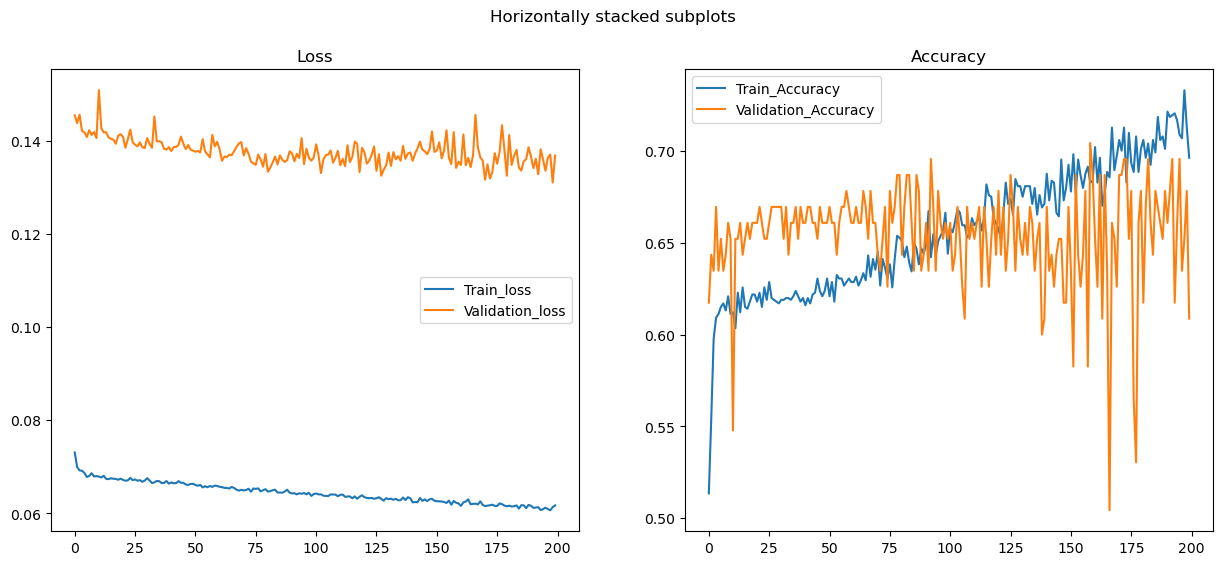

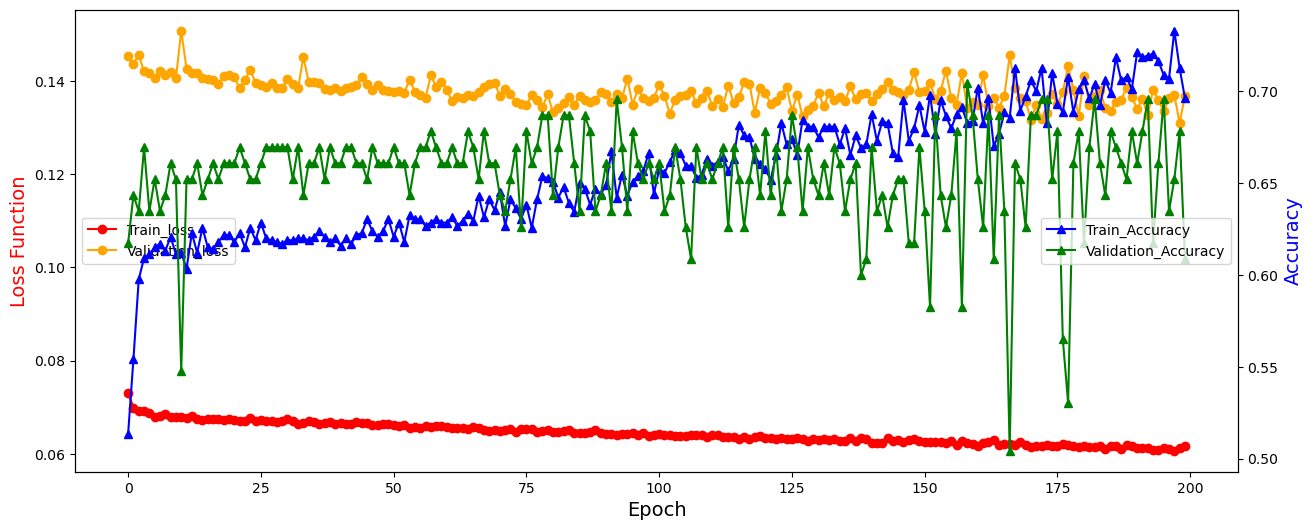

Current time: 64.734 minutes. Time expected till completion: 97.100 minutes

Epoch 201 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.06147696899260958
Val loss:  0.13226533143416694
train accuracy:  0.7166344294003868
Val accuracy:  0.6782608695652174
Current time: 65.056 minutes. Time expected till completion: 96.775 minutes

Epoch 202 of 500


100%|██████████| 15/15 [00:00<00:00, 16.74it/s]


train loss:  0.060987990817894557
Val loss:  0.13611828399741133
train accuracy:  0.7205029013539652
Val accuracy:  0.6521739130434783
Current time: 65.378 minutes. Time expected till completion: 96.449 minutes

Epoch 203 of 500


100%|██████████| 15/15 [00:00<00:00, 17.12it/s]


train loss:  0.06103676868822404
Val loss:  0.1360013230987217
train accuracy:  0.7137330754352031
Val accuracy:  0.6956521739130435
Current time: 65.709 minutes. Time expected till completion: 96.136 minutes

Epoch 204 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.060952234199014806
Val loss:  0.13191151929938275
train accuracy:  0.7224371373307543
Val accuracy:  0.6782608695652174
Current time: 66.035 minutes. Time expected till completion: 95.815 minutes

Epoch 205 of 500


100%|██████████| 15/15 [00:00<00:00, 17.28it/s]


train loss:  0.06137397135941157
Val loss:  0.1388523044793502
train accuracy:  0.7195357833655706
Val accuracy:  0.6434782608695652
Current time: 66.372 minutes. Time expected till completion: 95.511 minutes

Epoch 206 of 500


100%|██████████| 15/15 [00:00<00:00, 15.99it/s]


train loss:  0.06126016793444724
Val loss:  0.13165309325508448
train accuracy:  0.7253384912959381
Val accuracy:  0.6956521739130435
Current time: 66.709 minutes. Time expected till completion: 95.207 minutes

Epoch 207 of 500


100%|██████████| 15/15 [00:00<00:00, 16.59it/s]


train loss:  0.06135673276229799
Val loss:  0.1319170241770537
train accuracy:  0.7195357833655706
Val accuracy:  0.7043478260869566
Current time: 67.023 minutes. Time expected till completion: 94.869 minutes

Epoch 208 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.06140030525639163
Val loss:  0.13570108206375786
train accuracy:  0.7176015473887815
Val accuracy:  0.6347826086956522
Current time: 67.356 minutes. Time expected till completion: 94.557 minutes

Epoch 209 of 500


100%|██████████| 15/15 [00:00<00:00, 17.52it/s]


train loss:  0.060511183692592715
Val loss:  0.13451724207919577
train accuracy:  0.730174081237911
Val accuracy:  0.6608695652173913
Current time: 67.680 minutes. Time expected till completion: 94.234 minutes

Epoch 210 of 500


100%|██████████| 15/15 [00:00<00:00, 15.80it/s]


train loss:  0.060770313041122556
Val loss:  0.1410635207010352
train accuracy:  0.7408123791102514
Val accuracy:  0.6173913043478261
Current time: 68.016 minutes. Time expected till completion: 93.927 minutes

Epoch 211 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.061115833557781905
Val loss:  0.13525949561077616
train accuracy:  0.7059961315280464
Val accuracy:  0.6521739130434783
Current time: 68.352 minutes. Time expected till completion: 93.619 minutes

Epoch 212 of 500


100%|██████████| 15/15 [00:00<00:00, 16.65it/s]


train loss:  0.0610320623423652
Val loss:  0.14235224153684534
train accuracy:  0.7224371373307543
Val accuracy:  0.6521739130434783
Current time: 68.703 minutes. Time expected till completion: 93.333 minutes

Epoch 213 of 500


100%|██████████| 15/15 [00:00<00:00, 17.42it/s]


train loss:  0.06106198485400276
Val loss:  0.13363631860069605
train accuracy:  0.7137330754352031
Val accuracy:  0.6608695652173913
Current time: 69.037 minutes. Time expected till completion: 93.022 minutes

Epoch 214 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.06001771897135205
Val loss:  0.13852053310560145
train accuracy:  0.741779497098646
Val accuracy:  0.6521739130434783
Current time: 69.370 minutes. Time expected till completion: 92.710 minutes

Epoch 215 of 500


100%|██████████| 15/15 [00:00<00:00, 16.59it/s]


train loss:  0.06080652188286329
Val loss:  0.13324917192044466
train accuracy:  0.730174081237911
Val accuracy:  0.6869565217391305
Current time: 69.702 minutes. Time expected till completion: 92.395 minutes

Epoch 216 of 500


100%|██████████| 15/15 [00:00<00:00, 17.81it/s]


train loss:  0.06121102770938172
Val loss:  0.1358188297437585
train accuracy:  0.7127659574468085
Val accuracy:  0.6608695652173913
Current time: 70.020 minutes. Time expected till completion: 92.064 minutes

Epoch 217 of 500


100%|██████████| 15/15 [00:00<00:00, 16.08it/s]


train loss:  0.06058462364761234
Val loss:  0.1380641880242721
train accuracy:  0.7195357833655706
Val accuracy:  0.6347826086956522
Current time: 70.352 minutes. Time expected till completion: 91.750 minutes

Epoch 218 of 500


100%|██████████| 15/15 [00:00<00:00, 17.14it/s]


train loss:  0.06041414208522848
Val loss:  0.13914907548738562
train accuracy:  0.7311411992263056
Val accuracy:  0.6347826086956522
Current time: 70.678 minutes. Time expected till completion: 91.427 minutes

Epoch 219 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.0606317490166345
Val loss:  0.1372729322184687
train accuracy:  0.7147001934235977
Val accuracy:  0.6782608695652174
Current time: 71.013 minutes. Time expected till completion: 91.117 minutes

Epoch 220 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.05998329723134954
Val loss:  0.13491572919099226
train accuracy:  0.7379110251450677
Val accuracy:  0.6782608695652174
Current time: 71.339 minutes. Time expected till completion: 90.795 minutes

Epoch 221 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.05979240303805073
Val loss:  0.1313122738962588
train accuracy:  0.7475822050290135
Val accuracy:  0.7043478260869566
Current time: 71.660 minutes. Time expected till completion: 90.466 minutes

Epoch 222 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.0603864840889346
Val loss:  0.13934305284334267
train accuracy:  0.730174081237911
Val accuracy:  0.6260869565217392
Current time: 71.994 minutes. Time expected till completion: 90.154 minutes

Epoch 223 of 500


100%|██████████| 15/15 [00:00<00:00, 16.27it/s]


train loss:  0.061152273324287604
Val loss:  0.13575841447581416
train accuracy:  0.7147001934235977
Val accuracy:  0.6608695652173913
Current time: 72.321 minutes. Time expected till completion: 89.834 minutes

Epoch 224 of 500


100%|██████████| 15/15 [00:00<00:00, 16.23it/s]


train loss:  0.06063351519333786
Val loss:  0.13426896022713702
train accuracy:  0.7272727272727273
Val accuracy:  0.7217391304347827
Current time: 72.648 minutes. Time expected till completion: 89.513 minutes

Epoch 225 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06000582167673388
Val loss:  0.13619036104368126
train accuracy:  0.7282398452611218
Val accuracy:  0.6521739130434783
Current time: 72.975 minutes. Time expected till completion: 89.192 minutes

Epoch 226 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06003074045338068
Val loss:  0.13261739222899727
train accuracy:  0.7350096711798839
Val accuracy:  0.6608695652173913
Current time: 73.296 minutes. Time expected till completion: 88.864 minutes

Epoch 227 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.0600997156515804
Val loss:  0.1324412594670835
train accuracy:  0.7350096711798839
Val accuracy:  0.6869565217391305
Current time: 73.632 minutes. Time expected till completion: 88.554 minutes

Epoch 228 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.0611444111027155
Val loss:  0.13035806313804957
train accuracy:  0.7176015473887815
Val accuracy:  0.7043478260869566
Current time: 73.958 minutes. Time expected till completion: 88.230 minutes

Epoch 229 of 500


100%|██████████| 15/15 [00:00<00:00, 16.43it/s]


train loss:  0.060080882428462545
Val loss:  0.13345117983610733
train accuracy:  0.7359767891682786
Val accuracy:  0.7043478260869566
Current time: 74.282 minutes. Time expected till completion: 87.906 minutes

Epoch 230 of 500


100%|██████████| 15/15 [00:00<00:00, 16.04it/s]


train loss:  0.05971276293179053
Val loss:  0.13409027794133063
train accuracy:  0.7427466150870407
Val accuracy:  0.6956521739130435
Current time: 74.615 minutes. Time expected till completion: 87.591 minutes

Epoch 231 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06008073358978478
Val loss:  0.13546772055003953
train accuracy:  0.7456479690522244
Val accuracy:  0.6086956521739131
Current time: 74.943 minutes. Time expected till completion: 87.272 minutes

Epoch 232 of 500


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


train loss:  0.06050285316528158
Val loss:  0.13435506406037703
train accuracy:  0.7408123791102514
Val accuracy:  0.6521739130434783
Current time: 75.277 minutes. Time expected till completion: 86.958 minutes

Epoch 233 of 500


100%|██████████| 15/15 [00:00<00:00, 17.42it/s]


train loss:  0.06042128080786773
Val loss:  0.13774864880935006
train accuracy:  0.7321083172147002
Val accuracy:  0.6608695652173913
Current time: 75.616 minutes. Time expected till completion: 86.650 minutes

Epoch 234 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.059710427225212526
Val loss:  0.1349970729454704
train accuracy:  0.7495164410058027
Val accuracy:  0.6782608695652174
Current time: 75.939 minutes. Time expected till completion: 86.324 minutes

Epoch 235 of 500


100%|██████████| 15/15 [00:00<00:00, 16.01it/s]


train loss:  0.06020591268225842
Val loss:  0.13452700583831123
train accuracy:  0.7398452611218569
Val accuracy:  0.6608695652173913
Current time: 76.276 minutes. Time expected till completion: 86.014 minutes

Epoch 236 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.06038515820263433
Val loss:  0.13778784948846567
train accuracy:  0.7388781431334622
Val accuracy:  0.6086956521739131
Current time: 76.629 minutes. Time expected till completion: 85.721 minutes

Epoch 237 of 500


100%|██████████| 15/15 [00:00<00:00, 16.18it/s]


train loss:  0.0601125685804356
Val loss:  0.13672584813574087
train accuracy:  0.7321083172147002
Val accuracy:  0.6521739130434783
Current time: 76.965 minutes. Time expected till completion: 85.408 minutes

Epoch 238 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.05954579510356748
Val loss:  0.13075016996134883
train accuracy:  0.7369439071566731
Val accuracy:  0.6782608695652174
Current time: 77.311 minutes. Time expected till completion: 85.107 minutes

Epoch 239 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.0602696083154623
Val loss:  0.14346610255863357
train accuracy:  0.7485493230174082
Val accuracy:  0.5565217391304348
Current time: 77.657 minutes. Time expected till completion: 84.806 minutes

Epoch 240 of 500


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]


train loss:  0.06008695777887532
Val loss:  0.13309234380722046
train accuracy:  0.7437137330754352
Val accuracy:  0.6782608695652174
Current time: 77.996 minutes. Time expected till completion: 84.496 minutes

Epoch 241 of 500


100%|██████████| 15/15 [00:00<00:00, 15.91it/s]


train loss:  0.05945525161302297
Val loss:  0.13924026489257812
train accuracy:  0.7456479690522244
Val accuracy:  0.6434782608695652
Current time: 78.342 minutes. Time expected till completion: 84.193 minutes

Epoch 242 of 500


100%|██████████| 15/15 [00:00<00:00, 15.46it/s]


train loss:  0.059790166710977165
Val loss:  0.13415503450061964
train accuracy:  0.7437137330754352
Val accuracy:  0.6434782608695652
Current time: 78.714 minutes. Time expected till completion: 83.918 minutes

Epoch 243 of 500


100%|██████████| 15/15 [00:00<00:00, 17.73it/s]


train loss:  0.05961302539596705
Val loss:  0.13236780166625978
train accuracy:  0.758220502901354
Val accuracy:  0.6695652173913044
Current time: 79.067 minutes. Time expected till completion: 83.622 minutes

Epoch 244 of 500


100%|██████████| 15/15 [00:00<00:00, 16.32it/s]


train loss:  0.0600432533360081
Val loss:  0.13838367203007573
train accuracy:  0.7272727272727273
Val accuracy:  0.6521739130434783
Current time: 79.404 minutes. Time expected till completion: 83.309 minutes

Epoch 245 of 500


100%|██████████| 15/15 [00:00<00:00, 15.89it/s]


train loss:  0.05912762292349131
Val loss:  0.13832823089931323
train accuracy:  0.7524177949709865
Val accuracy:  0.6608695652173913
Current time: 79.757 minutes. Time expected till completion: 83.013 minutes

Epoch 246 of 500


100%|██████████| 15/15 [00:00<00:00, 16.08it/s]


train loss:  0.05964616263858124
Val loss:  0.13699712753295898
train accuracy:  0.7514506769825918
Val accuracy:  0.6608695652173913
Current time: 80.113 minutes. Time expected till completion: 82.718 minutes

Epoch 247 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.05970676684287346
Val loss:  0.13689812214478203
train accuracy:  0.753384912959381
Val accuracy:  0.6695652173913044
Current time: 80.455 minutes. Time expected till completion: 82.409 minutes

Epoch 248 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.059633464716389285
Val loss:  0.1392162841299306
train accuracy:  0.746615087040619
Val accuracy:  0.6173913043478261
Current time: 80.799 minutes. Time expected till completion: 82.102 minutes

Epoch 249 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.05893243304534853
Val loss:  0.1379065689833268
train accuracy:  0.7601547388781431
Val accuracy:  0.6347826086956522
Current time: 81.142 minutes. Time expected till completion: 81.794 minutes

Epoch 250 of 500


100%|██████████| 15/15 [00:00<00:00, 17.79it/s]


train loss:  0.05952341085015229
Val loss:  0.13726034216258837
train accuracy:  0.7514506769825918
Val accuracy:  0.6347826086956522
Current time: 81.478 minutes. Time expected till completion: 81.478 minutes

Epoch 251 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.059719049319538434
Val loss:  0.1387963626695716
train accuracy:  0.7562862669245648
Val accuracy:  0.6695652173913044
Current time: 81.815 minutes. Time expected till completion: 81.163 minutes

Epoch 252 of 500


100%|██████████| 15/15 [00:00<00:00, 15.85it/s]


train loss:  0.05959445716564614
Val loss:  0.1337944948154947
train accuracy:  0.7553191489361702
Val accuracy:  0.6956521739130435
Current time: 82.157 minutes. Time expected till completion: 80.853 minutes

Epoch 253 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.059330197724890205
Val loss:  0.13461352949557098
train accuracy:  0.7591876208897486
Val accuracy:  0.7217391304347827
Current time: 82.505 minutes. Time expected till completion: 80.548 minutes

Epoch 254 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.060232275920403075
Val loss:  0.136071835393491
train accuracy:  0.7369439071566731
Val accuracy:  0.6608695652173913
Current time: 82.844 minutes. Time expected till completion: 80.235 minutes

Epoch 255 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.05881866259316642
Val loss:  0.135946059745291
train accuracy:  0.7630560928433269
Val accuracy:  0.6869565217391305
Current time: 83.175 minutes. Time expected till completion: 79.914 minutes

Epoch 256 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.05917742260420115
Val loss:  0.14191131850947505
train accuracy:  0.7504835589941973
Val accuracy:  0.5739130434782609
Current time: 83.484 minutes. Time expected till completion: 79.571 minutes

Epoch 257 of 500


100%|██████████| 15/15 [00:00<00:00, 17.14it/s]


train loss:  0.059397397638520144
Val loss:  0.13548575121423473
train accuracy:  0.7611218568665378
Val accuracy:  0.6782608695652174
Current time: 83.848 minutes. Time expected till completion: 79.281 minutes

Epoch 258 of 500


100%|██████████| 15/15 [00:00<00:00, 16.59it/s]


train loss:  0.05954386031604597
Val loss:  0.13650616044583527
train accuracy:  0.7553191489361702
Val accuracy:  0.6347826086956522
Current time: 84.234 minutes. Time expected till completion: 79.010 minutes

Epoch 259 of 500


100%|██████████| 15/15 [00:00<00:00, 15.28it/s]


train loss:  0.059099800927957205
Val loss:  0.13220585014509117
train accuracy:  0.758220502901354
Val accuracy:  0.6956521739130435
Current time: 84.630 minutes. Time expected till completion: 78.748 minutes

Epoch 260 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.058816990550297606
Val loss:  0.13573465036309285
train accuracy:  0.769825918762089
Val accuracy:  0.6782608695652174
Current time: 84.974 minutes. Time expected till completion: 78.438 minutes

Epoch 261 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.05891667021081803
Val loss:  0.13626496325368467
train accuracy:  0.7659574468085106
Val accuracy:  0.6869565217391305
Current time: 85.328 minutes. Time expected till completion: 78.135 minutes

Epoch 262 of 500


100%|██████████| 15/15 [00:00<00:00, 15.20it/s]


train loss:  0.05959442321290361
Val loss:  0.13637908334317414
train accuracy:  0.7524177949709865
Val accuracy:  0.6869565217391305
Current time: 85.671 minutes. Time expected till completion: 77.824 minutes

Epoch 263 of 500


100%|██████████| 15/15 [00:01<00:00, 14.44it/s]


train loss:  0.05881176765006561
Val loss:  0.13462648391723633
train accuracy:  0.7659574468085106
Val accuracy:  0.6695652173913044
Current time: 86.065 minutes. Time expected till completion: 77.556 minutes

Epoch 264 of 500


100%|██████████| 15/15 [00:00<00:00, 15.71it/s]


train loss:  0.0588264789295381
Val loss:  0.1370425794435584
train accuracy:  0.7620889748549323
Val accuracy:  0.6521739130434783
Current time: 86.404 minutes. Time expected till completion: 77.240 minutes

Epoch 265 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.059860597726685394
Val loss:  0.13729843056720237
train accuracy:  0.7562862669245648
Val accuracy:  0.6782608695652174
Current time: 86.754 minutes. Time expected till completion: 76.933 minutes

Epoch 266 of 500


100%|██████████| 15/15 [00:00<00:00, 16.13it/s]


train loss:  0.058924423599150934
Val loss:  0.13260439997134002
train accuracy:  0.7591876208897486
Val accuracy:  0.6695652173913044
Current time: 87.086 minutes. Time expected till completion: 76.610 minutes

Epoch 267 of 500


100%|██████████| 15/15 [00:00<00:00, 15.96it/s]


train loss:  0.05925106471926839
Val loss:  0.1394246344980986
train accuracy:  0.7562862669245648
Val accuracy:  0.6173913043478261
Current time: 87.426 minutes. Time expected till completion: 76.293 minutes

Epoch 268 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.05919293814286503
Val loss:  0.13757232894068178
train accuracy:  0.7572533849129593
Val accuracy:  0.6434782608695652
Current time: 87.813 minutes. Time expected till completion: 76.017 minutes

Epoch 269 of 500


100%|██████████| 15/15 [00:00<00:00, 16.16it/s]


train loss:  0.05909998152887798
Val loss:  0.13494722946830418
train accuracy:  0.7736943907156673
Val accuracy:  0.6956521739130435
Current time: 88.178 minutes. Time expected till completion: 75.722 minutes

Epoch 270 of 500


100%|██████████| 15/15 [00:00<00:00, 16.06it/s]


train loss:  0.0590675836374958
Val loss:  0.13710126928661182
train accuracy:  0.7649903288201161
Val accuracy:  0.6608695652173913
Current time: 88.588 minutes. Time expected till completion: 75.464 minutes

Epoch 271 of 500


100%|██████████| 15/15 [00:00<00:00, 15.89it/s]


train loss:  0.05835648016496138
Val loss:  0.13805857844974684
train accuracy:  0.7669245647969052
Val accuracy:  0.6347826086956522
Current time: 88.957 minutes. Time expected till completion: 75.170 minutes

Epoch 272 of 500


100%|██████████| 15/15 [00:00<00:00, 16.85it/s]


train loss:  0.058880349365378254
Val loss:  0.1361866717753203
train accuracy:  0.7601547388781431
Val accuracy:  0.6782608695652174
Current time: 89.298 minutes. Time expected till completion: 74.853 minutes

Epoch 273 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.058281823848617374
Val loss:  0.1397308665773143
train accuracy:  0.7630560928433269
Val accuracy:  0.591304347826087
Current time: 89.683 minutes. Time expected till completion: 74.572 minutes

Epoch 274 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.05863463123485706
Val loss:  0.13218961902286697
train accuracy:  0.7669245647969052
Val accuracy:  0.6782608695652174
Current time: 90.045 minutes. Time expected till completion: 74.271 minutes

Epoch 275 of 500


100%|██████████| 15/15 [00:00<00:00, 15.45it/s]


train loss:  0.05853982785684228
Val loss:  0.13684965579406075
train accuracy:  0.7669245647969052
Val accuracy:  0.6695652173913044
Current time: 90.406 minutes. Time expected till completion: 73.969 minutes

Epoch 276 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.05871578970315147
Val loss:  0.13262035639389702
train accuracy:  0.758220502901354
Val accuracy:  0.6695652173913044
Current time: 90.754 minutes. Time expected till completion: 73.655 minutes

Epoch 277 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.05874517900109061
Val loss:  0.13384131348651387
train accuracy:  0.7746615087040619
Val accuracy:  0.6695652173913044
Current time: 91.117 minutes. Time expected till completion: 73.354 minutes

Epoch 278 of 500


100%|██████████| 15/15 [00:00<00:00, 15.14it/s]


train loss:  0.058632650389200944
Val loss:  0.1376539365105007
train accuracy:  0.7553191489361702
Val accuracy:  0.6347826086956522
Current time: 91.510 minutes. Time expected till completion: 73.076 minutes

Epoch 279 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.05816857704110948
Val loss:  0.13146756006323773
train accuracy:  0.7785299806576402
Val accuracy:  0.6869565217391305
Current time: 91.864 minutes. Time expected till completion: 72.767 minutes

Epoch 280 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.058540236615581255
Val loss:  0.1355143490044967
train accuracy:  0.7872340425531915
Val accuracy:  0.6782608695652174
Current time: 92.201 minutes. Time expected till completion: 72.443 minutes

Epoch 281 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.0592024099780697
Val loss:  0.1393578705580338
train accuracy:  0.7553191489361702
Val accuracy:  0.6521739130434783
Current time: 92.562 minutes. Time expected till completion: 72.139 minutes

Epoch 282 of 500


100%|██████████| 15/15 [00:00<00:00, 16.50it/s]


train loss:  0.058842187347449004
Val loss:  0.1371202106061189
train accuracy:  0.7640232108317214
Val accuracy:  0.6434782608695652
Current time: 92.878 minutes. Time expected till completion: 71.800 minutes

Epoch 283 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.05871978206145694
Val loss:  0.13325253828712133
train accuracy:  0.7611218568665378
Val accuracy:  0.7130434782608696
Current time: 93.199 minutes. Time expected till completion: 71.464 minutes

Epoch 284 of 500


100%|██████████| 15/15 [00:00<00:00, 15.86it/s]


train loss:  0.05839735286839926
Val loss:  0.1369295586710391
train accuracy:  0.7717601547388782
Val accuracy:  0.6782608695652174
Current time: 93.529 minutes. Time expected till completion: 71.134 minutes

Epoch 285 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.05820081542953993
Val loss:  0.13436962521594503
train accuracy:  0.7794970986460348
Val accuracy:  0.6608695652173913
Current time: 93.865 minutes. Time expected till completion: 70.810 minutes

Epoch 286 of 500


100%|██████████| 15/15 [00:00<00:00, 15.80it/s]


train loss:  0.0586457607017495
Val loss:  0.135873209911844
train accuracy:  0.781431334622824
Val accuracy:  0.6869565217391305
Current time: 94.186 minutes. Time expected till completion: 70.475 minutes

Epoch 287 of 500


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


train loss:  0.058474331287166365
Val loss:  0.13787815881812054
train accuracy:  0.7727272727272727
Val accuracy:  0.6695652173913044
Current time: 94.502 minutes. Time expected till completion: 70.135 minutes

Epoch 288 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.05809893206885981
Val loss:  0.14152393185574075
train accuracy:  0.7775628626692457
Val accuracy:  0.6521739130434783
Current time: 94.819 minutes. Time expected till completion: 69.798 minutes

Epoch 289 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.05755609861886709
Val loss:  0.14217681003653485
train accuracy:  0.7852998065764023
Val accuracy:  0.6695652173913044
Current time: 95.136 minutes. Time expected till completion: 69.459 minutes

Epoch 290 of 500


100%|██████████| 15/15 [00:01<00:00, 14.67it/s]


train loss:  0.05806199315668766
Val loss:  0.13332723793776138
train accuracy:  0.7872340425531915
Val accuracy:  0.6608695652173913
Current time: 95.522 minutes. Time expected till completion: 69.171 minutes

Epoch 291 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.05756334260077264
Val loss:  0.13672078847885133
train accuracy:  0.7852998065764023
Val accuracy:  0.6521739130434783
Current time: 95.858 minutes. Time expected till completion: 68.847 minutes

Epoch 292 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.05822133672075991
Val loss:  0.1327564659325973
train accuracy:  0.7794970986460348
Val accuracy:  0.6695652173913044
Current time: 96.184 minutes. Time expected till completion: 68.515 minutes

Epoch 293 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.058054391546913456
Val loss:  0.14310006162394648
train accuracy:  0.7882011605415861
Val accuracy:  0.6347826086956522
Current time: 96.489 minutes. Time expected till completion: 68.168 minutes

Epoch 294 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.05798341354041773
Val loss:  0.13425717405650928
train accuracy:  0.7833655705996132
Val accuracy:  0.6695652173913044
Current time: 96.789 minutes. Time expected till completion: 67.818 minutes

Epoch 295 of 500


100%|██████████| 15/15 [00:00<00:00, 15.76it/s]


train loss:  0.05707365118788566
Val loss:  0.1379424053689708
train accuracy:  0.804642166344294
Val accuracy:  0.6347826086956522
Current time: 97.181 minutes. Time expected till completion: 67.532 minutes

Epoch 296 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.057422196034997756
Val loss:  0.14091838546421218
train accuracy:  0.7959381044487428
Val accuracy:  0.6347826086956522
Current time: 97.530 minutes. Time expected till completion: 67.216 minutes

Epoch 297 of 500


100%|██████████| 15/15 [00:01<00:00, 14.87it/s]


train loss:  0.05830777285177426
Val loss:  0.13947132670361062
train accuracy:  0.7833655705996132
Val accuracy:  0.6521739130434783
Current time: 97.904 minutes. Time expected till completion: 66.917 minutes

Epoch 298 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.057649944690947835
Val loss:  0.13756075060885886
train accuracy:  0.7901353965183753
Val accuracy:  0.6782608695652174
Current time: 98.263 minutes. Time expected till completion: 66.608 minutes

Epoch 299 of 500


100%|██████████| 15/15 [00:01<00:00, 14.56it/s]


train loss:  0.05826307922544055
Val loss:  0.12957118283147398
train accuracy:  0.7756286266924565
Val accuracy:  0.7043478260869566
Current time: 98.650 minutes. Time expected till completion: 66.317 minutes

Epoch 300 of 500


100%|██████████| 15/15 [00:00<00:00, 15.37it/s]


train loss:  0.05747578966087253
Val loss:  0.1733053456182065
train accuracy:  0.7882011605415861
Val accuracy:  0.3739130434782609
Saving model checkpoint


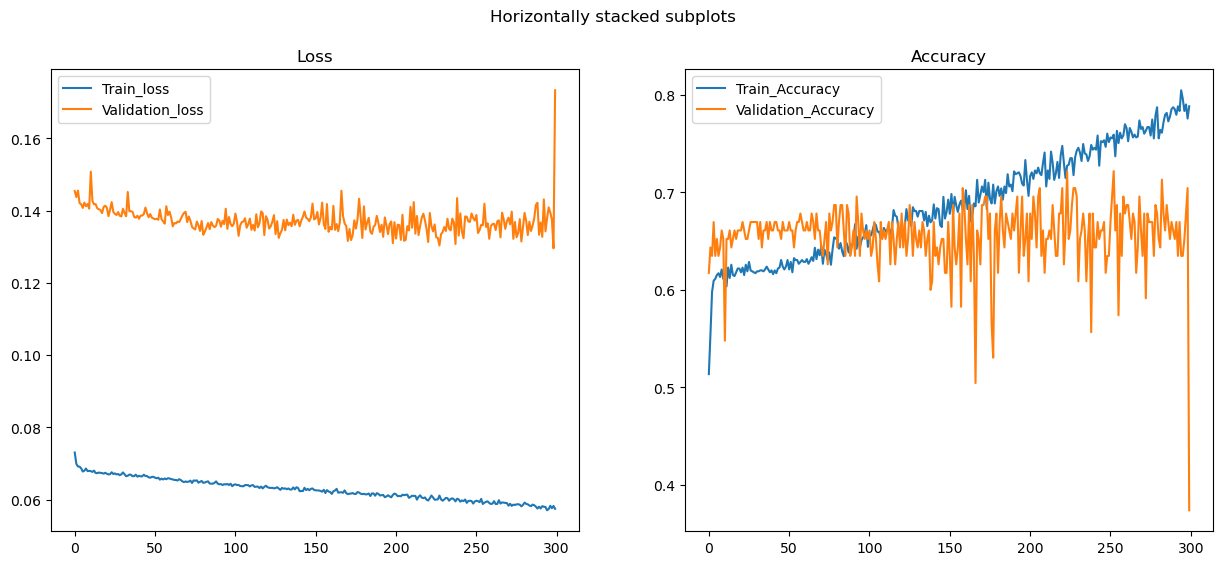

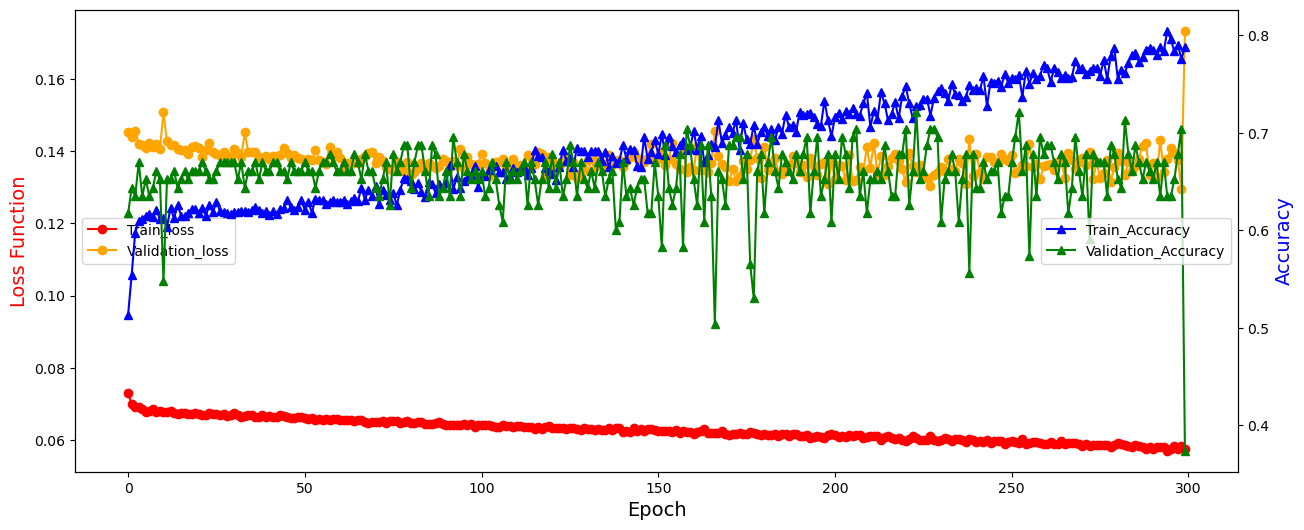

Current time: 99.033 minutes. Time expected till completion: 66.022 minutes

Epoch 301 of 500


100%|██████████| 15/15 [00:01<00:00, 14.61it/s]


train loss:  0.05811649370700755
Val loss:  0.1402439630549887
train accuracy:  0.7823984526112185
Val accuracy:  0.6086956521739131
Current time: 99.412 minutes. Time expected till completion: 65.724 minutes

Epoch 302 of 500


100%|██████████| 15/15 [00:01<00:00, 14.11it/s]


train loss:  0.05776065443885626
Val loss:  0.13507135121718697
train accuracy:  0.7940038684719536
Val accuracy:  0.6782608695652174
Current time: 99.809 minutes. Time expected till completion: 65.438 minutes

Epoch 303 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.057238394333269424
Val loss:  0.13981140489163607
train accuracy:  0.8123791102514507
Val accuracy:  0.6695652173913044
Current time: 100.193 minutes. Time expected till completion: 65.142 minutes

Epoch 304 of 500


100%|██████████| 15/15 [00:00<00:00, 15.06it/s]


train loss:  0.057499772978935756
Val loss:  0.13967923703400986
train accuracy:  0.7978723404255319
Val accuracy:  0.6434782608695652
Current time: 100.554 minutes. Time expected till completion: 64.831 minutes

Epoch 305 of 500


100%|██████████| 15/15 [00:00<00:00, 17.02it/s]


train loss:  0.057651234779874404
Val loss:  0.13168082859205163
train accuracy:  0.7988394584139265
Val accuracy:  0.7217391304347827
Current time: 100.932 minutes. Time expected till completion: 64.530 minutes

Epoch 306 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.0579739052737474
Val loss:  0.13254511045373005
train accuracy:  0.7911025145067698
Val accuracy:  0.6782608695652174
Current time: 101.313 minutes. Time expected till completion: 64.231 minutes

Epoch 307 of 500


100%|██████████| 15/15 [00:00<00:00, 17.46it/s]


train loss:  0.057620533430368805
Val loss:  0.13852785462918488
train accuracy:  0.7959381044487428
Val accuracy:  0.6434782608695652
Current time: 101.697 minutes. Time expected till completion: 63.933 minutes

Epoch 308 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.05706156020699433
Val loss:  0.13862789195516836
train accuracy:  0.7998065764023211
Val accuracy:  0.6695652173913044
Current time: 102.008 minutes. Time expected till completion: 63.590 minutes

Epoch 309 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.05789220592500624
Val loss:  0.1402237866235816
train accuracy:  0.8104448742746615
Val accuracy:  0.6086956521739131
Current time: 102.303 minutes. Time expected till completion: 63.236 minutes

Epoch 310 of 500


100%|██████████| 15/15 [00:00<00:00, 16.77it/s]


train loss:  0.05667276919695118
Val loss:  0.13569651116495546
train accuracy:  0.8191489361702128
Val accuracy:  0.6956521739130435
Current time: 102.601 minutes. Time expected till completion: 62.884 minutes

Epoch 311 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.05737846928362229
Val loss:  0.14168059359426083
train accuracy:  0.8017408123791102
Val accuracy:  0.5652173913043478
Current time: 102.897 minutes. Time expected till completion: 62.532 minutes

Epoch 312 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.057695425974792394
Val loss:  0.1440598612246306
train accuracy:  0.7794970986460348
Val accuracy:  0.5739130434782609
Current time: 103.193 minutes. Time expected till completion: 62.180 minutes

Epoch 313 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.05724327482383994
Val loss:  0.1390322509019271
train accuracy:  0.793036750483559
Val accuracy:  0.6434782608695652
Current time: 103.489 minutes. Time expected till completion: 61.829 minutes

Epoch 314 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.056820933546734044
Val loss:  0.1388201926065528
train accuracy:  0.8210831721470019
Val accuracy:  0.6521739130434783
Current time: 103.788 minutes. Time expected till completion: 61.479 minutes

Epoch 315 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.056954227056447954
Val loss:  0.13798178952673207
train accuracy:  0.8133462282398453
Val accuracy:  0.6782608695652174
Current time: 104.084 minutes. Time expected till completion: 61.129 minutes

Epoch 316 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.05691853061866022
Val loss:  0.13376670557519663
train accuracy:  0.8036750483558994
Val accuracy:  0.6782608695652174
Current time: 104.385 minutes. Time expected till completion: 60.781 minutes

Epoch 317 of 500


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


train loss:  0.05675048569876636
Val loss:  0.13439316853233005
train accuracy:  0.8172147001934236
Val accuracy:  0.6782608695652174
Current time: 104.682 minutes. Time expected till completion: 60.432 minutes

Epoch 318 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.05695197015020787
Val loss:  0.1379280370214711
train accuracy:  0.8104448742746615
Val accuracy:  0.6434782608695652
Current time: 104.976 minutes. Time expected till completion: 60.081 minutes

Epoch 319 of 500


100%|██████████| 15/15 [00:00<00:00, 18.43it/s]


train loss:  0.05673533920162651
Val loss:  0.13260598441828853
train accuracy:  0.8249516441005803
Val accuracy:  0.6521739130434783
Current time: 105.269 minutes. Time expected till completion: 59.729 minutes

Epoch 320 of 500


100%|██████████| 15/15 [00:00<00:00, 17.97it/s]


train loss:  0.05763814349008483
Val loss:  0.1356179988902548
train accuracy:  0.7969052224371374
Val accuracy:  0.6521739130434783
Current time: 105.563 minutes. Time expected till completion: 59.379 minutes

Epoch 321 of 500


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


train loss:  0.05738615661110131
Val loss:  0.13186375006385473
train accuracy:  0.7998065764023211
Val accuracy:  0.6521739130434783
Current time: 105.857 minutes. Time expected till completion: 59.029 minutes

Epoch 322 of 500


100%|██████████| 15/15 [00:00<00:00, 18.03it/s]


train loss:  0.056472585959867996
Val loss:  0.1415973564852839
train accuracy:  0.8249516441005803
Val accuracy:  0.6521739130434783
Current time: 106.150 minutes. Time expected till completion: 58.679 minutes

Epoch 323 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.05670934938600492
Val loss:  0.13107192464496778
train accuracy:  0.8104448742746615
Val accuracy:  0.7217391304347827
Current time: 106.444 minutes. Time expected till completion: 58.330 minutes

Epoch 324 of 500


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


train loss:  0.056772809886378985
Val loss:  0.13950137262759002
train accuracy:  0.8239845261121856
Val accuracy:  0.6434782608695652
Current time: 106.738 minutes. Time expected till completion: 57.981 minutes

Epoch 325 of 500


100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


train loss:  0.05649163592714867
Val loss:  0.13763946916746056
train accuracy:  0.8152804642166345
Val accuracy:  0.6
Current time: 107.032 minutes. Time expected till completion: 57.633 minutes

Epoch 326 of 500


100%|██████████| 15/15 [00:00<00:00, 16.71it/s]


train loss:  0.05697373380052283
Val loss:  0.1404532650242681
train accuracy:  0.8017408123791102
Val accuracy:  0.6
Current time: 107.328 minutes. Time expected till completion: 57.285 minutes

Epoch 327 of 500


100%|██████████| 15/15 [00:00<00:00, 18.68it/s]


train loss:  0.05702340078307766
Val loss:  0.13694091724312824
train accuracy:  0.8085106382978723
Val accuracy:  0.6260869565217392
Current time: 107.625 minutes. Time expected till completion: 56.939 minutes

Epoch 328 of 500


100%|██████████| 15/15 [00:00<00:00, 17.86it/s]


train loss:  0.05641927225677372
Val loss:  0.13634675222894418
train accuracy:  0.8268858800773694
Val accuracy:  0.6434782608695652
Current time: 107.917 minutes. Time expected till completion: 56.591 minutes

Epoch 329 of 500


100%|██████████| 15/15 [00:00<00:00, 17.76it/s]


train loss:  0.05674763626240669
Val loss:  0.14053418999132902
train accuracy:  0.8278529980657641
Val accuracy:  0.6260869565217392
Current time: 108.211 minutes. Time expected till completion: 56.243 minutes

Epoch 330 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.0565211342889059
Val loss:  0.13615492996962175
train accuracy:  0.8288201160541586
Val accuracy:  0.6782608695652174
Current time: 108.506 minutes. Time expected till completion: 55.897 minutes

Epoch 331 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.055843194806137676
Val loss:  0.13281216414078423
train accuracy:  0.8375241779497099
Val accuracy:  0.6956521739130435
Current time: 108.802 minutes. Time expected till completion: 55.552 minutes

Epoch 332 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.05563519027523653
Val loss:  0.1356977597526882
train accuracy:  0.8336557059961315
Val accuracy:  0.6608695652173913
Current time: 109.098 minutes. Time expected till completion: 55.206 minutes

Epoch 333 of 500


100%|██████████| 15/15 [00:00<00:00, 18.71it/s]


train loss:  0.05638748384306002
Val loss:  0.14053960157477338
train accuracy:  0.8239845261121856
Val accuracy:  0.6173913043478261
Current time: 109.393 minutes. Time expected till completion: 54.861 minutes

Epoch 334 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.05580894870960966
Val loss:  0.14082242250442506
train accuracy:  0.8346228239845261
Val accuracy:  0.6086956521739131
Current time: 109.696 minutes. Time expected till completion: 54.520 minutes

Epoch 335 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.05673804619787279
Val loss:  0.13651243344597194
train accuracy:  0.8123791102514507
Val accuracy:  0.6521739130434783
Current time: 109.989 minutes. Time expected till completion: 54.174 minutes

Epoch 336 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.055778537716579625
Val loss:  0.14137739824212114
train accuracy:  0.8471953578336557
Val accuracy:  0.6260869565217392
Current time: 110.283 minutes. Time expected till completion: 53.829 minutes

Epoch 337 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.05645052353694775
Val loss:  0.14153675203738006
train accuracy:  0.8210831721470019
Val accuracy:  0.6
Current time: 110.579 minutes. Time expected till completion: 53.485 minutes

Epoch 338 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.05681197480721907
Val loss:  0.13649636714354804
train accuracy:  0.8297872340425532
Val accuracy:  0.6695652173913044
Current time: 110.870 minutes. Time expected till completion: 53.139 minutes

Epoch 339 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.05682246044018743
Val loss:  0.1382754263670548
train accuracy:  0.8249516441005803
Val accuracy:  0.6608695652173913
Current time: 111.164 minutes. Time expected till completion: 52.795 minutes

Epoch 340 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.0563104347518611
Val loss:  0.14103828150293102
train accuracy:  0.8317214700193424
Val accuracy:  0.6173913043478261
Current time: 111.457 minutes. Time expected till completion: 52.451 minutes

Epoch 341 of 500


100%|██████████| 15/15 [00:00<00:00, 16.77it/s]


train loss:  0.057049916030359915
Val loss:  0.1316524018412051
train accuracy:  0.8152804642166345
Val accuracy:  0.6347826086956522
Current time: 111.751 minutes. Time expected till completion: 52.107 minutes

Epoch 342 of 500


100%|██████████| 15/15 [00:00<00:00, 18.50it/s]


train loss:  0.056028316110891346
Val loss:  0.13413640105206034
train accuracy:  0.8288201160541586
Val accuracy:  0.6695652173913044
Current time: 112.043 minutes. Time expected till completion: 51.762 minutes

Epoch 343 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.05660227782721676
Val loss:  0.1385223881058071
train accuracy:  0.8172147001934236
Val accuracy:  0.6608695652173913
Current time: 112.342 minutes. Time expected till completion: 51.422 minutes

Epoch 344 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.05636673266468011
Val loss:  0.13888178804646367
train accuracy:  0.8239845261121856
Val accuracy:  0.6782608695652174
Current time: 112.635 minutes. Time expected till completion: 51.079 minutes

Epoch 345 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.05553693743692837
Val loss:  0.1402389458988024
train accuracy:  0.8307543520309478
Val accuracy:  0.5826086956521739
Current time: 112.929 minutes. Time expected till completion: 50.736 minutes

Epoch 346 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.05561771031966292
Val loss:  0.13706700542698735
train accuracy:  0.8375241779497099
Val accuracy:  0.6434782608695652
Current time: 113.223 minutes. Time expected till completion: 50.394 minutes

Epoch 347 of 500


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


train loss:  0.055624617886958314
Val loss:  0.13524679256522137
train accuracy:  0.8462282398452611
Val accuracy:  0.7043478260869566
Current time: 113.517 minutes. Time expected till completion: 50.052 minutes

Epoch 348 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.055232882211471206
Val loss:  0.1402379616447117
train accuracy:  0.8433268858800773
Val accuracy:  0.6347826086956522
Current time: 113.812 minutes. Time expected till completion: 49.711 minutes

Epoch 349 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.05565562602168587
Val loss:  0.13448560756185782
train accuracy:  0.8452611218568665
Val accuracy:  0.6869565217391305
Current time: 114.105 minutes. Time expected till completion: 49.369 minutes

Epoch 350 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.056021203443667414
Val loss:  0.13583154211873594
train accuracy:  0.8336557059961315
Val accuracy:  0.7043478260869566
Current time: 114.399 minutes. Time expected till completion: 49.028 minutes

Epoch 351 of 500


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


train loss:  0.05513982529566412
Val loss:  0.13603188162264618
train accuracy:  0.8375241779497099
Val accuracy:  0.6521739130434783
Current time: 114.697 minutes. Time expected till completion: 48.689 minutes

Epoch 352 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.055806025833871425
Val loss:  0.1415524151014245
train accuracy:  0.8307543520309478
Val accuracy:  0.6173913043478261
Current time: 114.993 minutes. Time expected till completion: 48.349 minutes

Epoch 353 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.05508180859010501
Val loss:  0.13454023184983627
train accuracy:  0.8413926499032882
Val accuracy:  0.6956521739130435
Current time: 115.287 minutes. Time expected till completion: 48.009 minutes

Epoch 354 of 500


100%|██████████| 15/15 [00:00<00:00, 18.01it/s]


train loss:  0.055690096010322494
Val loss:  0.13577463056730188
train accuracy:  0.8326885880077369
Val accuracy:  0.6782608695652174
Current time: 115.581 minutes. Time expected till completion: 47.669 minutes

Epoch 355 of 500


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


train loss:  0.05545239170699793
Val loss:  0.13488285437874173
train accuracy:  0.8413926499032882
Val accuracy:  0.7043478260869566
Current time: 115.876 minutes. Time expected till completion: 47.329 minutes

Epoch 356 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.056251124671626136
Val loss:  0.139946913200876
train accuracy:  0.8297872340425532
Val accuracy:  0.6347826086956522
Current time: 116.170 minutes. Time expected till completion: 46.990 minutes

Epoch 357 of 500


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


train loss:  0.055171991916413005
Val loss:  0.1436973177868387
train accuracy:  0.8433268858800773
Val accuracy:  0.6173913043478261
Current time: 116.463 minutes. Time expected till completion: 46.650 minutes

Epoch 358 of 500


100%|██████████| 15/15 [00:00<00:00, 18.57it/s]


train loss:  0.05482149308608625
Val loss:  0.13611008965450785
train accuracy:  0.8549323017408124
Val accuracy:  0.6695652173913044
Current time: 116.757 minutes. Time expected till completion: 46.311 minutes

Epoch 359 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.05507006416929529
Val loss:  0.13931528951810754
train accuracy:  0.8568665377176016
Val accuracy:  0.6260869565217392
Current time: 117.050 minutes. Time expected till completion: 45.972 minutes

Epoch 360 of 500


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


train loss:  0.055365091827436846
Val loss:  0.13315741342046986
train accuracy:  0.8413926499032882
Val accuracy:  0.7217391304347827
Current time: 117.344 minutes. Time expected till completion: 45.634 minutes

Epoch 361 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.054900193986855805
Val loss:  0.13805618856264198
train accuracy:  0.8568665377176016
Val accuracy:  0.6608695652173913
Current time: 117.640 minutes. Time expected till completion: 45.296 minutes

Epoch 362 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.055045191566072536
Val loss:  0.1390801834023517
train accuracy:  0.8529980657640233
Val accuracy:  0.6521739130434783
Current time: 117.934 minutes. Time expected till completion: 44.958 minutes

Epoch 363 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.05498981354776157
Val loss:  0.14950186117835668
train accuracy:  0.8626692456479691
Val accuracy:  0.5391304347826087
Current time: 118.231 minutes. Time expected till completion: 44.621 minutes

Epoch 364 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.05654208491803138
Val loss:  0.13790744076604428
train accuracy:  0.8249516441005803
Val accuracy:  0.6695652173913044
Current time: 118.528 minutes. Time expected till completion: 44.285 minutes

Epoch 365 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.055265872287104625
Val loss:  0.1420021590979203
train accuracy:  0.8568665377176016
Val accuracy:  0.6347826086956522
Current time: 118.822 minutes. Time expected till completion: 43.948 minutes

Epoch 366 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.05452004443976589
Val loss:  0.13468321199002473
train accuracy:  0.8607350096711799
Val accuracy:  0.6869565217391305
Current time: 119.114 minutes. Time expected till completion: 43.610 minutes

Epoch 367 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.0548730215897182
Val loss:  0.1375613077827122
train accuracy:  0.8520309477756286
Val accuracy:  0.6695652173913044
Current time: 119.407 minutes. Time expected till completion: 43.273 minutes

Epoch 368 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.05553499734609224
Val loss:  0.13470565909924714
train accuracy:  0.8326885880077369
Val accuracy:  0.6695652173913044
Current time: 119.702 minutes. Time expected till completion: 42.937 minutes

Epoch 369 of 500


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


train loss:  0.05455538561311866
Val loss:  0.13980624312939852
train accuracy:  0.8636363636363636
Val accuracy:  0.6608695652173913
Current time: 119.994 minutes. Time expected till completion: 42.599 minutes

Epoch 370 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.05532297347915472
Val loss:  0.13888534825781118
train accuracy:  0.8375241779497099
Val accuracy:  0.6695652173913044
Current time: 120.290 minutes. Time expected till completion: 42.264 minutes

Epoch 371 of 500


100%|██████████| 15/15 [00:00<00:00, 17.76it/s]


train loss:  0.05457675554996763
Val loss:  0.14218501267225847
train accuracy:  0.8655705996131529
Val accuracy:  0.6086956521739131
Current time: 120.584 minutes. Time expected till completion: 41.928 minutes

Epoch 372 of 500


100%|██████████| 15/15 [00:00<00:00, 18.64it/s]


train loss:  0.054598967503302336
Val loss:  0.1382503991541655
train accuracy:  0.8597678916827853
Val accuracy:  0.6608695652173913
Current time: 120.878 minutes. Time expected till completion: 41.593 minutes

Epoch 373 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.05450908294959963
Val loss:  0.14104827227799788
train accuracy:  0.8578336557059961
Val accuracy:  0.6347826086956522
Current time: 121.170 minutes. Time expected till completion: 41.256 minutes

Epoch 374 of 500


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


train loss:  0.05478241324885901
Val loss:  0.1330685003944065
train accuracy:  0.8452611218568665
Val accuracy:  0.6695652173913044
Current time: 121.464 minutes. Time expected till completion: 40.921 minutes

Epoch 375 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.0554040483049544
Val loss:  0.1318111839501754
train accuracy:  0.8452611218568665
Val accuracy:  0.6956521739130435
Current time: 121.757 minutes. Time expected till completion: 40.586 minutes

Epoch 376 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.055254688922395094
Val loss:  0.1411009783330171
train accuracy:  0.8520309477756286
Val accuracy:  0.6173913043478261
Current time: 122.051 minutes. Time expected till completion: 40.251 minutes

Epoch 377 of 500


100%|██████████| 15/15 [00:00<00:00, 18.25it/s]


train loss:  0.05452001878786364
Val loss:  0.14394761894060218
train accuracy:  0.8655705996131529
Val accuracy:  0.591304347826087
Current time: 122.345 minutes. Time expected till completion: 39.916 minutes

Epoch 378 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.05443217802785582
Val loss:  0.13771174005840137
train accuracy:  0.8636363636363636
Val accuracy:  0.6434782608695652
Current time: 122.638 minutes. Time expected till completion: 39.582 minutes

Epoch 379 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.05423863125493033
Val loss:  0.14178332867829696
train accuracy:  0.8665377176015474
Val accuracy:  0.6608695652173913
Current time: 122.933 minutes. Time expected till completion: 39.248 minutes

Epoch 380 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.05422915250235877
Val loss:  0.1371497480765633
train accuracy:  0.8694390715667312
Val accuracy:  0.6782608695652174
Current time: 123.225 minutes. Time expected till completion: 38.913 minutes

Epoch 381 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.05530091007627417
Val loss:  0.13648695790249368
train accuracy:  0.8520309477756286
Val accuracy:  0.6086956521739131
Current time: 123.519 minutes. Time expected till completion: 38.579 minutes

Epoch 382 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.05410277318908352
Val loss:  0.13966539113417917
train accuracy:  0.8694390715667312
Val accuracy:  0.6086956521739131
Current time: 123.813 minutes. Time expected till completion: 38.246 minutes

Epoch 383 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.0537983006734682
Val loss:  0.13690133353938228
train accuracy:  0.8858800773694391
Val accuracy:  0.6434782608695652
Current time: 124.109 minutes. Time expected till completion: 37.913 minutes

Epoch 384 of 500


100%|██████████| 15/15 [00:00<00:00, 17.74it/s]


train loss:  0.05379357444017953
Val loss:  0.14019892578539642
train accuracy:  0.8781431334622823
Val accuracy:  0.6347826086956522
Current time: 124.408 minutes. Time expected till completion: 37.582 minutes

Epoch 385 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.05474673767846142
Val loss:  0.1405487817266713
train accuracy:  0.8597678916827853
Val accuracy:  0.6260869565217392
Current time: 124.700 minutes. Time expected till completion: 37.248 minutes

Epoch 386 of 500


100%|██████████| 15/15 [00:00<00:00, 18.78it/s]


train loss:  0.05388584715715921
Val loss:  0.13763587630313376
train accuracy:  0.874274661508704
Val accuracy:  0.6608695652173913
Current time: 124.994 minutes. Time expected till completion: 36.915 minutes

Epoch 387 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.05492998114868105
Val loss:  0.1384846759879071
train accuracy:  0.8549323017408124
Val accuracy:  0.6695652173913044
Current time: 125.287 minutes. Time expected till completion: 36.582 minutes

Epoch 388 of 500


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


train loss:  0.05379389506013527
Val loss:  0.1442289570103521
train accuracy:  0.8810444874274661
Val accuracy:  0.6
Current time: 125.579 minutes. Time expected till completion: 36.250 minutes

Epoch 389 of 500


100%|██████████| 15/15 [00:00<00:00, 17.80it/s]


train loss:  0.054481260608197184
Val loss:  0.13518838675125786
train accuracy:  0.8626692456479691
Val accuracy:  0.6608695652173913
Current time: 125.873 minutes. Time expected till completion: 35.918 minutes

Epoch 390 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.05469040644699185
Val loss:  0.13865189396816752
train accuracy:  0.8549323017408124
Val accuracy:  0.6347826086956522
Current time: 126.172 minutes. Time expected till completion: 35.587 minutes

Epoch 391 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.05488822296463544
Val loss:  0.136070658331332
train accuracy:  0.8597678916827853
Val accuracy:  0.6782608695652174
Current time: 126.468 minutes. Time expected till completion: 35.256 minutes

Epoch 392 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.054553542595998
Val loss:  0.13917401407075966
train accuracy:  0.8597678916827853
Val accuracy:  0.6347826086956522
Current time: 126.762 minutes. Time expected till completion: 34.924 minutes

Epoch 393 of 500


100%|██████████| 15/15 [00:00<00:00, 18.75it/s]


train loss:  0.05433551808621021
Val loss:  0.13780336069024127
train accuracy:  0.8597678916827853
Val accuracy:  0.6608695652173913
Current time: 127.055 minutes. Time expected till completion: 34.593 minutes

Epoch 394 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.0537300808517338
Val loss:  0.14287643847258194
train accuracy:  0.8762088974854932
Val accuracy:  0.6086956521739131
Current time: 127.348 minutes. Time expected till completion: 34.261 minutes

Epoch 395 of 500


100%|██████████| 15/15 [00:00<00:00, 17.97it/s]


train loss:  0.05404434760949598
Val loss:  0.13592268332191135
train accuracy:  0.8800773694390716
Val accuracy:  0.6782608695652174
Current time: 127.641 minutes. Time expected till completion: 33.930 minutes

Epoch 396 of 500


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


train loss:  0.05365246257652858
Val loss:  0.1416301411131154
train accuracy:  0.8810444874274661
Val accuracy:  0.6
Current time: 127.935 minutes. Time expected till completion: 33.599 minutes

Epoch 397 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.05359156818869497
Val loss:  0.1361503269361413
train accuracy:  0.879110251450677
Val accuracy:  0.6608695652173913
Current time: 128.230 minutes. Time expected till completion: 33.269 minutes

Epoch 398 of 500


100%|██████████| 15/15 [00:00<00:00, 18.50it/s]


train loss:  0.054152725628312366
Val loss:  0.13522292116413945
train accuracy:  0.8684719535783365
Val accuracy:  0.6695652173913044
Current time: 128.525 minutes. Time expected till completion: 32.939 minutes

Epoch 399 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.05402239724791949
Val loss:  0.13880079673684162
train accuracy:  0.8723404255319149
Val accuracy:  0.6434782608695652
Current time: 128.821 minutes. Time expected till completion: 32.609 minutes

Epoch 400 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.05380725964356207
Val loss:  0.13801211792489756
train accuracy:  0.8684719535783365
Val accuracy:  0.6521739130434783
Saving model checkpoint


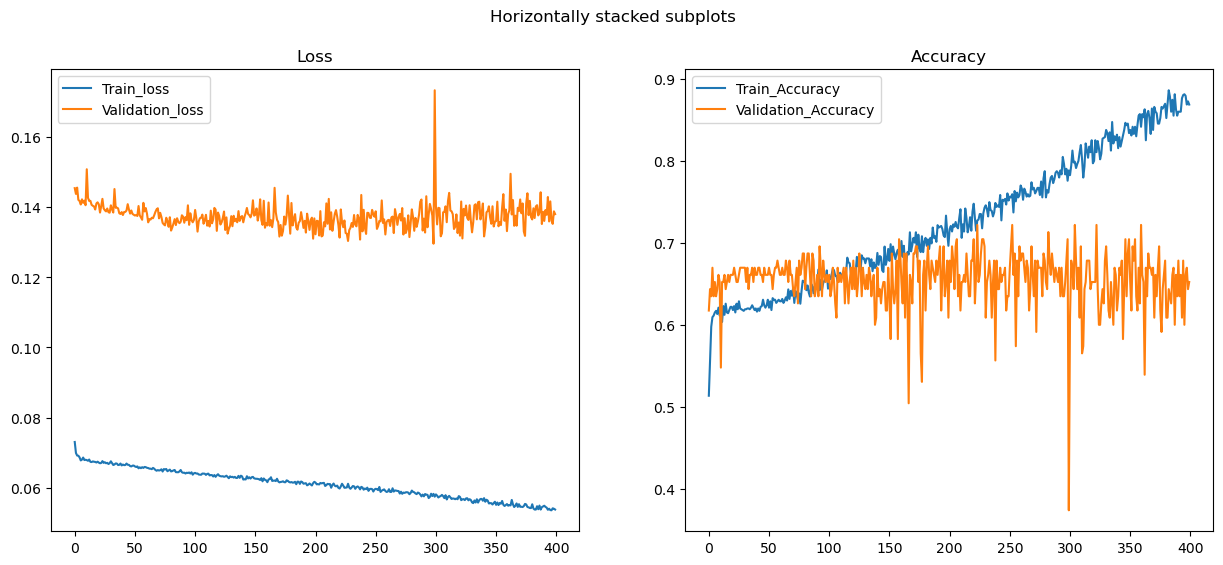

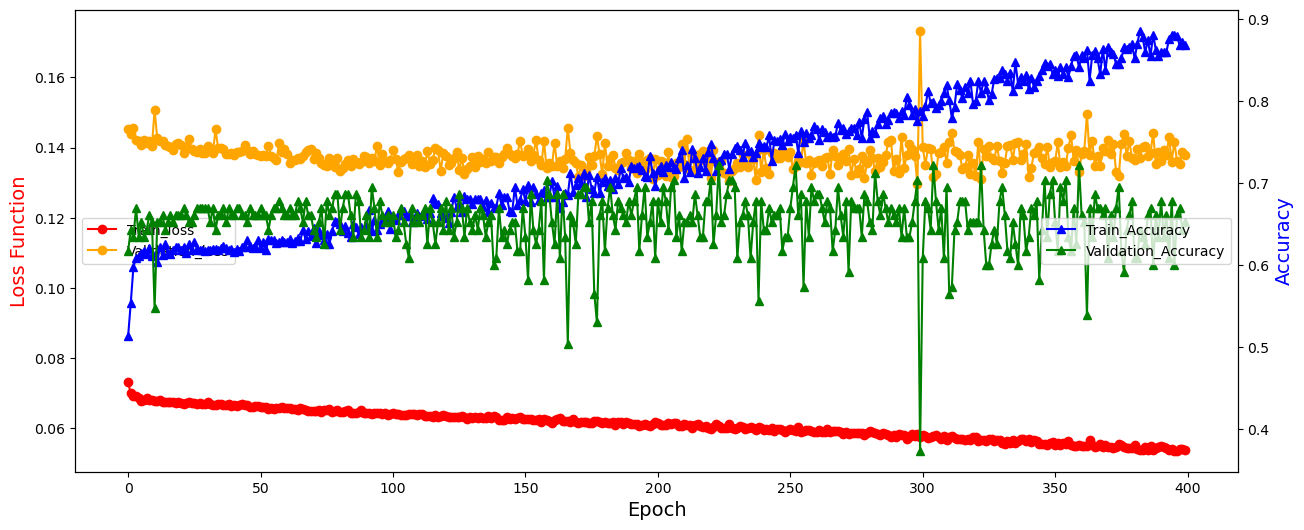

Current time: 129.133 minutes. Time expected till completion: 32.283 minutes

Epoch 401 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.05427102355477427
Val loss:  0.13760900186455768
train accuracy:  0.8617021276595744
Val accuracy:  0.6260869565217392
Current time: 129.428 minutes. Time expected till completion: 31.954 minutes

Epoch 402 of 500


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


train loss:  0.053517413554385274
Val loss:  0.13849598998608798
train accuracy:  0.879110251450677
Val accuracy:  0.6347826086956522
Current time: 129.721 minutes. Time expected till completion: 31.624 minutes

Epoch 403 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.05432473443001797
Val loss:  0.14038294761077216
train accuracy:  0.8636363636363636
Val accuracy:  0.6260869565217392
Current time: 130.016 minutes. Time expected till completion: 31.294 minutes

Epoch 404 of 500


100%|██████████| 15/15 [00:00<00:00, 18.39it/s]


train loss:  0.05307167180502207
Val loss:  0.13862481376399163
train accuracy:  0.8994197292069632
Val accuracy:  0.6521739130434783
Current time: 130.311 minutes. Time expected till completion: 30.965 minutes

Epoch 405 of 500


100%|██████████| 15/15 [00:00<00:00, 18.50it/s]


train loss:  0.053669390122710624
Val loss:  0.13706337369006613
train accuracy:  0.8849129593810445
Val accuracy:  0.6521739130434783
Current time: 130.606 minutes. Time expected till completion: 30.636 minutes

Epoch 406 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.053623165337213924
Val loss:  0.13855482132538505
train accuracy:  0.8800773694390716
Val accuracy:  0.6347826086956522
Current time: 130.904 minutes. Time expected till completion: 30.308 minutes

Epoch 407 of 500


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


train loss:  0.052588433315491075
Val loss:  0.1350037569585054
train accuracy:  0.9013539651837524
Val accuracy:  0.6521739130434783
Current time: 131.199 minutes. Time expected till completion: 29.979 minutes

Epoch 408 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.05337078070963375
Val loss:  0.14625200395998747
train accuracy:  0.8858800773694391
Val accuracy:  0.591304347826087
Current time: 131.492 minutes. Time expected till completion: 29.650 minutes

Epoch 409 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.0534646516265906
Val loss:  0.138209300974141
train accuracy:  0.8878143133462283
Val accuracy:  0.6608695652173913
Current time: 131.791 minutes. Time expected till completion: 29.323 minutes

Epoch 410 of 500


100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


train loss:  0.05341168125547339
Val loss:  0.1339714941771134
train accuracy:  0.8858800773694391
Val accuracy:  0.7043478260869566
Current time: 132.084 minutes. Time expected till completion: 28.994 minutes

Epoch 411 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.053703071012718304
Val loss:  0.13242406067640886
train accuracy:  0.8829787234042553
Val accuracy:  0.6956521739130435
Current time: 132.382 minutes. Time expected till completion: 28.667 minutes

Epoch 412 of 500


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


train loss:  0.05382388420907395
Val loss:  0.14243558334267659
train accuracy:  0.8752417794970987
Val accuracy:  0.6173913043478261
Current time: 132.676 minutes. Time expected till completion: 28.339 minutes

Epoch 413 of 500


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


train loss:  0.05403347944613813
Val loss:  0.14054359249446702
train accuracy:  0.8636363636363636
Val accuracy:  0.6521739130434783
Current time: 132.968 minutes. Time expected till completion: 28.010 minutes

Epoch 414 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.05345697859500317
Val loss:  0.12975636306016342
train accuracy:  0.879110251450677
Val accuracy:  0.6608695652173913
Current time: 133.263 minutes. Time expected till completion: 27.683 minutes

Epoch 415 of 500


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


train loss:  0.052947515733468
Val loss:  0.13139344609302023
train accuracy:  0.8945841392649904
Val accuracy:  0.6956521739130435
Current time: 133.556 minutes. Time expected till completion: 27.355 minutes

Epoch 416 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.05383238617179472
Val loss:  0.12916668497997782
train accuracy:  0.8723404255319149
Val accuracy:  0.7304347826086957
Current time: 133.850 minutes. Time expected till completion: 27.027 minutes

Epoch 417 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.0537848425326541
Val loss:  0.13983793465987496
train accuracy:  0.8820116054158608
Val accuracy:  0.6434782608695652
Current time: 134.143 minutes. Time expected till completion: 26.700 minutes

Epoch 418 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.053682706111634955
Val loss:  0.13464793070502903
train accuracy:  0.8752417794970987
Val accuracy:  0.6434782608695652
Current time: 134.436 minutes. Time expected till completion: 26.373 minutes

Epoch 419 of 500


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


train loss:  0.05350662471016786
Val loss:  0.13843221094297326
train accuracy:  0.8858800773694391
Val accuracy:  0.6608695652173913
Current time: 134.730 minutes. Time expected till completion: 26.046 minutes

Epoch 420 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.05371468429178057
Val loss:  0.14544383961221446
train accuracy:  0.879110251450677
Val accuracy:  0.5826086956521739
Current time: 135.025 minutes. Time expected till completion: 25.719 minutes

Epoch 421 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.05441690257946804
Val loss:  0.13771151615225752
train accuracy:  0.8588007736943907
Val accuracy:  0.6434782608695652
Current time: 135.320 minutes. Time expected till completion: 25.393 minutes

Epoch 422 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.05360547319141071
Val loss:  0.13526914638021717
train accuracy:  0.8839458413926499
Val accuracy:  0.6521739130434783
Current time: 135.613 minutes. Time expected till completion: 25.066 minutes

Epoch 423 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.05321180376600712
Val loss:  0.1353222333866617
train accuracy:  0.8887814313346228
Val accuracy:  0.6956521739130435
Current time: 135.908 minutes. Time expected till completion: 24.740 minutes

Epoch 424 of 500


100%|██████████| 15/15 [00:00<00:00, 17.90it/s]


train loss:  0.05297793560378556
Val loss:  0.14156541409699813
train accuracy:  0.8878143133462283
Val accuracy:  0.6347826086956522
Current time: 136.202 minutes. Time expected till completion: 24.414 minutes

Epoch 425 of 500


100%|██████████| 15/15 [00:00<00:00, 18.32it/s]


train loss:  0.05250239677770456
Val loss:  0.1417059644408848
train accuracy:  0.9003868471953579
Val accuracy:  0.6521739130434783
Current time: 136.495 minutes. Time expected till completion: 24.087 minutes

Epoch 426 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.05312797277301146
Val loss:  0.13343860014625217
train accuracy:  0.8916827852998066
Val accuracy:  0.6956521739130435
Current time: 136.791 minutes. Time expected till completion: 23.762 minutes

Epoch 427 of 500


100%|██████████| 15/15 [00:00<00:00, 16.86it/s]


train loss:  0.05267196178897437
Val loss:  0.13627761913382488
train accuracy:  0.9061895551257253
Val accuracy:  0.6260869565217392
Current time: 137.085 minutes. Time expected till completion: 23.436 minutes

Epoch 428 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.052748324100929715
Val loss:  0.13784618274025295
train accuracy:  0.9100580270793037
Val accuracy:  0.6695652173913044
Current time: 137.377 minutes. Time expected till completion: 23.110 minutes

Epoch 429 of 500


100%|██████████| 15/15 [00:00<00:00, 18.71it/s]


train loss:  0.05312766201030355
Val loss:  0.1344272395838862
train accuracy:  0.8878143133462283
Val accuracy:  0.6956521739130435
Current time: 137.673 minutes. Time expected till completion: 22.785 minutes

Epoch 430 of 500


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


train loss:  0.05336169451763367
Val loss:  0.13709788166958353
train accuracy:  0.8878143133462283
Val accuracy:  0.6347826086956522
Current time: 137.966 minutes. Time expected till completion: 22.460 minutes

Epoch 431 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.05326220848574168
Val loss:  0.13748683722122856
train accuracy:  0.8849129593810445
Val accuracy:  0.6869565217391305
Current time: 138.260 minutes. Time expected till completion: 22.134 minutes

Epoch 432 of 500


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


train loss:  0.05346717571612714
Val loss:  0.13270749682965485
train accuracy:  0.8955512572533849
Val accuracy:  0.7130434782608696
Current time: 138.556 minutes. Time expected till completion: 21.810 minutes

Epoch 433 of 500


100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


train loss:  0.05303814442291481
Val loss:  0.13333126513854318
train accuracy:  0.8916827852998066
Val accuracy:  0.7304347826086957
Current time: 138.850 minutes. Time expected till completion: 21.485 minutes

Epoch 434 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.052481224101101634
Val loss:  0.13769272617671802
train accuracy:  0.9081237911025145
Val accuracy:  0.6782608695652174
Current time: 139.149 minutes. Time expected till completion: 21.161 minutes

Epoch 435 of 500


100%|██████████| 15/15 [00:00<00:00, 18.82it/s]


train loss:  0.053398679603229866
Val loss:  0.13806902999463289
train accuracy:  0.8849129593810445
Val accuracy:  0.6260869565217392
Current time: 139.443 minutes. Time expected till completion: 20.836 minutes

Epoch 436 of 500


100%|██████████| 15/15 [00:00<00:00, 16.77it/s]


train loss:  0.05290965652327473
Val loss:  0.13537672395291536
train accuracy:  0.8858800773694391
Val accuracy:  0.6869565217391305
Current time: 139.737 minutes. Time expected till completion: 20.512 minutes

Epoch 437 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.0532592392060005
Val loss:  0.134909130697665
train accuracy:  0.8858800773694391
Val accuracy:  0.6956521739130435
Current time: 140.031 minutes. Time expected till completion: 20.187 minutes

Epoch 438 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.052779395183696044
Val loss:  0.14120161015054453
train accuracy:  0.8965183752417795
Val accuracy:  0.6434782608695652
Current time: 140.330 minutes. Time expected till completion: 19.864 minutes

Epoch 439 of 500


100%|██████████| 15/15 [00:00<00:00, 17.80it/s]


train loss:  0.052500524534708756
Val loss:  0.13835970007854959
train accuracy:  0.9003868471953579
Val accuracy:  0.6521739130434783
Current time: 140.623 minutes. Time expected till completion: 19.540 minutes

Epoch 440 of 500


100%|██████████| 15/15 [00:00<00:00, 17.90it/s]


train loss:  0.05244260599811488
Val loss:  0.1344219637953717
train accuracy:  0.902321083172147
Val accuracy:  0.6695652173913044
Current time: 140.919 minutes. Time expected till completion: 19.216 minutes

Epoch 441 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.052517869889851465
Val loss:  0.13950270725333172
train accuracy:  0.9042553191489362
Val accuracy:  0.6434782608695652
Current time: 141.216 minutes. Time expected till completion: 18.893 minutes

Epoch 442 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.052492951574362456
Val loss:  0.13891602650932644
train accuracy:  0.9013539651837524
Val accuracy:  0.6695652173913044
Current time: 141.516 minutes. Time expected till completion: 18.570 minutes

Epoch 443 of 500


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


train loss:  0.0521667772612212
Val loss:  0.14517888815506644
train accuracy:  0.9032882011605415
Val accuracy:  0.6
Current time: 141.810 minutes. Time expected till completion: 18.246 minutes

Epoch 444 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.05395100967565865
Val loss:  0.1409845082656197
train accuracy:  0.874274661508704
Val accuracy:  0.6
Current time: 142.105 minutes. Time expected till completion: 17.923 minutes

Epoch 445 of 500


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


train loss:  0.05282634652329598
Val loss:  0.13970136642456055
train accuracy:  0.8945841392649904
Val accuracy:  0.6434782608695652
Current time: 142.398 minutes. Time expected till completion: 17.600 minutes

Epoch 446 of 500


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


train loss:  0.052425030698167514
Val loss:  0.14171338962472002
train accuracy:  0.9003868471953579
Val accuracy:  0.6173913043478261
Current time: 142.693 minutes. Time expected till completion: 17.277 minutes

Epoch 447 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.05258930144503684
Val loss:  0.13680150042409484
train accuracy:  0.9052224371373307
Val accuracy:  0.6869565217391305
Current time: 142.988 minutes. Time expected till completion: 16.954 minutes

Epoch 448 of 500


100%|██████████| 15/15 [00:00<00:00, 18.59it/s]


train loss:  0.052772009856926864
Val loss:  0.13854717482691226
train accuracy:  0.902321083172147
Val accuracy:  0.6086956521739131
Current time: 143.282 minutes. Time expected till completion: 16.631 minutes

Epoch 449 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.05260198599365279
Val loss:  0.13447079451187796
train accuracy:  0.902321083172147
Val accuracy:  0.6869565217391305
Current time: 143.577 minutes. Time expected till completion: 16.308 minutes

Epoch 450 of 500


100%|██████████| 15/15 [00:00<00:00, 17.97it/s]


train loss:  0.052721167786670145
Val loss:  0.14478761372358903
train accuracy:  0.8907156673114119
Val accuracy:  0.6
Current time: 143.871 minutes. Time expected till completion: 15.986 minutes

Epoch 451 of 500


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]


train loss:  0.05170259064124677
Val loss:  0.13426533781963845
train accuracy:  0.9197292069632496
Val accuracy:  0.6956521739130435
Current time: 144.165 minutes. Time expected till completion: 15.663 minutes

Epoch 452 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.05232506079646097
Val loss:  0.13646631292674852
train accuracy:  0.9119922630560928
Val accuracy:  0.6869565217391305
Current time: 144.459 minutes. Time expected till completion: 15.341 minutes

Epoch 453 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.05249119531255165
Val loss:  0.14127248784770136
train accuracy:  0.9013539651837524
Val accuracy:  0.6347826086956522
Current time: 144.752 minutes. Time expected till completion: 15.018 minutes

Epoch 454 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.0520152952846291
Val loss:  0.1274166060530621
train accuracy:  0.9081237911025145
Val accuracy:  0.7652173913043478
Current time: 145.047 minutes. Time expected till completion: 14.696 minutes

Epoch 455 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.05223505876281045
Val loss:  0.13386216059975
train accuracy:  0.90715667311412
Val accuracy:  0.6869565217391305
Current time: 145.340 minutes. Time expected till completion: 14.374 minutes

Epoch 456 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.052340845190118314
Val loss:  0.13875163016111955
train accuracy:  0.9061895551257253
Val accuracy:  0.6521739130434783
Current time: 145.640 minutes. Time expected till completion: 14.053 minutes

Epoch 457 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.05252949360260881
Val loss:  0.13379412474839583
train accuracy:  0.8994197292069632
Val accuracy:  0.6956521739130435
Current time: 145.934 minutes. Time expected till completion: 13.731 minutes

Epoch 458 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.0515287652813489
Val loss:  0.14014728483946426
train accuracy:  0.9187620889748549
Val accuracy:  0.6173913043478261
Current time: 146.228 minutes. Time expected till completion: 13.410 minutes

Epoch 459 of 500


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


train loss:  0.05163299080481612
Val loss:  0.1365369615347489
train accuracy:  0.9129593810444874
Val accuracy:  0.6695652173913044
Current time: 146.522 minutes. Time expected till completion: 13.088 minutes

Epoch 460 of 500


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


train loss:  0.052191416172732236
Val loss:  0.14223467474398405
train accuracy:  0.9032882011605415
Val accuracy:  0.6173913043478261
Current time: 146.816 minutes. Time expected till completion: 12.767 minutes

Epoch 461 of 500


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


train loss:  0.051396900899636215
Val loss:  0.14382720926533574
train accuracy:  0.9284332688588007
Val accuracy:  0.6260869565217392
Current time: 147.111 minutes. Time expected till completion: 12.445 minutes

Epoch 462 of 500


100%|██████████| 15/15 [00:00<00:00, 18.50it/s]


train loss:  0.05185254762666138
Val loss:  0.13962872442991836
train accuracy:  0.9110251450676983
Val accuracy:  0.6347826086956522
Current time: 147.406 minutes. Time expected till completion: 12.124 minutes

Epoch 463 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.051726487722802666
Val loss:  0.13538760257803875
train accuracy:  0.9177949709864603
Val accuracy:  0.6869565217391305
Current time: 147.701 minutes. Time expected till completion: 11.803 minutes

Epoch 464 of 500


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


train loss:  0.05200746038665624
Val loss:  0.13714592197666997
train accuracy:  0.9119922630560928
Val accuracy:  0.6608695652173913
Current time: 147.995 minutes. Time expected till completion: 11.482 minutes

Epoch 465 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.05192397895126785
Val loss:  0.1377767889396004
train accuracy:  0.9206963249516441
Val accuracy:  0.6347826086956522
Current time: 148.288 minutes. Time expected till completion: 11.161 minutes

Epoch 466 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.051948359556769956
Val loss:  0.13657667947852092
train accuracy:  0.9042553191489362
Val accuracy:  0.6869565217391305
Current time: 148.586 minutes. Time expected till completion: 10.841 minutes

Epoch 467 of 500


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


train loss:  0.051853646450393205
Val loss:  0.13489116482112717
train accuracy:  0.9052224371373307
Val accuracy:  0.6608695652173913
Current time: 148.880 minutes. Time expected till completion: 10.520 minutes

Epoch 468 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.052092326333029355
Val loss:  0.1365278430607008
train accuracy:  0.90715667311412
Val accuracy:  0.6869565217391305
Current time: 149.174 minutes. Time expected till completion: 10.200 minutes

Epoch 469 of 500


100%|██████████| 15/15 [00:00<00:00, 18.41it/s]


train loss:  0.05166412068520109
Val loss:  0.1404939874358799
train accuracy:  0.9187620889748549
Val accuracy:  0.6347826086956522
Current time: 149.469 minutes. Time expected till completion: 9.880 minutes

Epoch 470 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.051306810035465764
Val loss:  0.13819896293723066
train accuracy:  0.9235976789168279
Val accuracy:  0.6608695652173913
Current time: 149.762 minutes. Time expected till completion: 9.559 minutes

Epoch 471 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.051633303527444656
Val loss:  0.13770410237104996
train accuracy:  0.9148936170212766
Val accuracy:  0.6782608695652174
Current time: 150.057 minutes. Time expected till completion: 9.239 minutes

Epoch 472 of 500


100%|██████████| 15/15 [00:00<00:00, 18.68it/s]


train loss:  0.05209061537997174
Val loss:  0.13783210256825323
train accuracy:  0.9100580270793037
Val accuracy:  0.6521739130434783
Current time: 150.350 minutes. Time expected till completion: 8.919 minutes

Epoch 473 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.051905928485859294
Val loss:  0.13323999436005302
train accuracy:  0.9177949709864603
Val accuracy:  0.6956521739130435
Current time: 150.644 minutes. Time expected till completion: 8.599 minutes

Epoch 474 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.05146823192242266
Val loss:  0.1339660592701124
train accuracy:  0.9226305609284333
Val accuracy:  0.7043478260869566
Current time: 150.938 minutes. Time expected till completion: 8.279 minutes

Epoch 475 of 500


100%|██████████| 15/15 [00:00<00:00, 16.79it/s]


train loss:  0.051808711119731114
Val loss:  0.13402308277461839
train accuracy:  0.9100580270793037
Val accuracy:  0.6956521739130435
Current time: 151.235 minutes. Time expected till completion: 7.960 minutes

Epoch 476 of 500


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


train loss:  0.052154726573992054
Val loss:  0.14494390384010647
train accuracy:  0.9100580270793037
Val accuracy:  0.6086956521739131
Current time: 151.527 minutes. Time expected till completion: 7.640 minutes

Epoch 477 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.051917556233747324
Val loss:  0.13500364034072213
train accuracy:  0.9061895551257253
Val accuracy:  0.6608695652173913
Current time: 151.823 minutes. Time expected till completion: 7.321 minutes

Epoch 478 of 500


100%|██████████| 15/15 [00:00<00:00, 18.32it/s]


train loss:  0.05168060799862476
Val loss:  0.1371063470840454
train accuracy:  0.9100580270793037
Val accuracy:  0.6608695652173913
Current time: 152.117 minutes. Time expected till completion: 7.001 minutes

Epoch 479 of 500


100%|██████████| 15/15 [00:00<00:00, 18.41it/s]


train loss:  0.05241374778101938
Val loss:  0.14074173440103946
train accuracy:  0.9081237911025145
Val accuracy:  0.6521739130434783
Current time: 152.410 minutes. Time expected till completion: 6.682 minutes

Epoch 480 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.0518115078688129
Val loss:  0.14078640574994294
train accuracy:  0.9168278529980658
Val accuracy:  0.6173913043478261
Current time: 152.705 minutes. Time expected till completion: 6.363 minutes

Epoch 481 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.05139461476752098
Val loss:  0.13752572795619136
train accuracy:  0.9226305609284333
Val accuracy:  0.6260869565217392
Current time: 152.999 minutes. Time expected till completion: 6.044 minutes

Epoch 482 of 500


100%|██████████| 15/15 [00:00<00:00, 18.68it/s]


train loss:  0.05096758593673632
Val loss:  0.1377819916476374
train accuracy:  0.9303675048355899
Val accuracy:  0.6521739130434783
Current time: 153.291 minutes. Time expected till completion: 5.725 minutes

Epoch 483 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.051510980096960896
Val loss:  0.13861509924349577
train accuracy:  0.9226305609284333
Val accuracy:  0.6434782608695652
Current time: 153.586 minutes. Time expected till completion: 5.406 minutes

Epoch 484 of 500


100%|██████████| 15/15 [00:00<00:00, 18.48it/s]


train loss:  0.05160267878777745
Val loss:  0.13744844509207685
train accuracy:  0.9158607350096711
Val accuracy:  0.6608695652173913
Current time: 153.880 minutes. Time expected till completion: 5.087 minutes

Epoch 485 of 500


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


train loss:  0.05145216760598483
Val loss:  0.13584363460540771
train accuracy:  0.9245647969052224
Val accuracy:  0.6782608695652174
Current time: 154.179 minutes. Time expected till completion: 4.768 minutes

Epoch 486 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.052534914454823535
Val loss:  0.14009967990543531
train accuracy:  0.8984526112185687
Val accuracy:  0.6260869565217392
Current time: 154.474 minutes. Time expected till completion: 4.450 minutes

Epoch 487 of 500


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


train loss:  0.05119111753524618
Val loss:  0.14332685937052186
train accuracy:  0.9294003868471954
Val accuracy:  0.6260869565217392
Current time: 154.767 minutes. Time expected till completion: 4.131 minutes

Epoch 488 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.05223969962426265
Val loss:  0.1306856932847396
train accuracy:  0.9042553191489362
Val accuracy:  0.7130434782608696
Current time: 155.062 minutes. Time expected till completion: 3.813 minutes

Epoch 489 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.051988453825852855
Val loss:  0.1413047370703324
train accuracy:  0.9168278529980658
Val accuracy:  0.6434782608695652
Current time: 155.356 minutes. Time expected till completion: 3.495 minutes

Epoch 490 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.052312887153035205
Val loss:  0.14092353893362958
train accuracy:  0.90715667311412
Val accuracy:  0.6173913043478261
Current time: 155.651 minutes. Time expected till completion: 3.177 minutes

Epoch 491 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.05132976745037322
Val loss:  0.1333483198414678
train accuracy:  0.925531914893617
Val accuracy:  0.6521739130434783
Current time: 155.945 minutes. Time expected till completion: 2.858 minutes

Epoch 492 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.05096651132378864
Val loss:  0.1378582705622134
train accuracy:  0.9313346228239845
Val accuracy:  0.6695652173913044
Current time: 156.243 minutes. Time expected till completion: 2.541 minutes

Epoch 493 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.05146754220329816
Val loss:  0.13784395197163457
train accuracy:  0.9216634429400387
Val accuracy:  0.6434782608695652
Current time: 156.541 minutes. Time expected till completion: 2.223 minutes

Epoch 494 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.05141887812365416
Val loss:  0.13350659090539682
train accuracy:  0.9245647969052224
Val accuracy:  0.6956521739130435
Current time: 156.838 minutes. Time expected till completion: 1.905 minutes

Epoch 495 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.0514600323639248
Val loss:  0.14083247132923293
train accuracy:  0.9245647969052224
Val accuracy:  0.6260869565217392
Current time: 157.132 minutes. Time expected till completion: 1.587 minutes

Epoch 496 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.05133916550033097
Val loss:  0.13876650437064794
train accuracy:  0.9245647969052224
Val accuracy:  0.6347826086956522
Current time: 157.426 minutes. Time expected till completion: 1.270 minutes

Epoch 497 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.05187297207474478
Val loss:  0.13714754374130914
train accuracy:  0.9148936170212766
Val accuracy:  0.6521739130434783
Current time: 157.722 minutes. Time expected till completion: 0.952 minutes

Epoch 498 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.05104288210951844
Val loss:  0.13705176581507145
train accuracy:  0.9284332688588007
Val accuracy:  0.6782608695652174
Current time: 158.017 minutes. Time expected till completion: 0.635 minutes

Epoch 499 of 500


100%|██████████| 15/15 [00:00<00:00, 17.80it/s]


train loss:  0.050870021318789836
Val loss:  0.13556083544440892
train accuracy:  0.9361702127659575
Val accuracy:  0.6782608695652174
Current time: 158.311 minutes. Time expected till completion: 0.317 minutes

Epoch 500 of 500


100%|██████████| 15/15 [00:00<00:00, 18.03it/s]


train loss:  0.05076165944049621
Val loss:  0.1359336132588594
train accuracy:  0.9361702127659575
Val accuracy:  0.6695652173913044
Saving model checkpoint


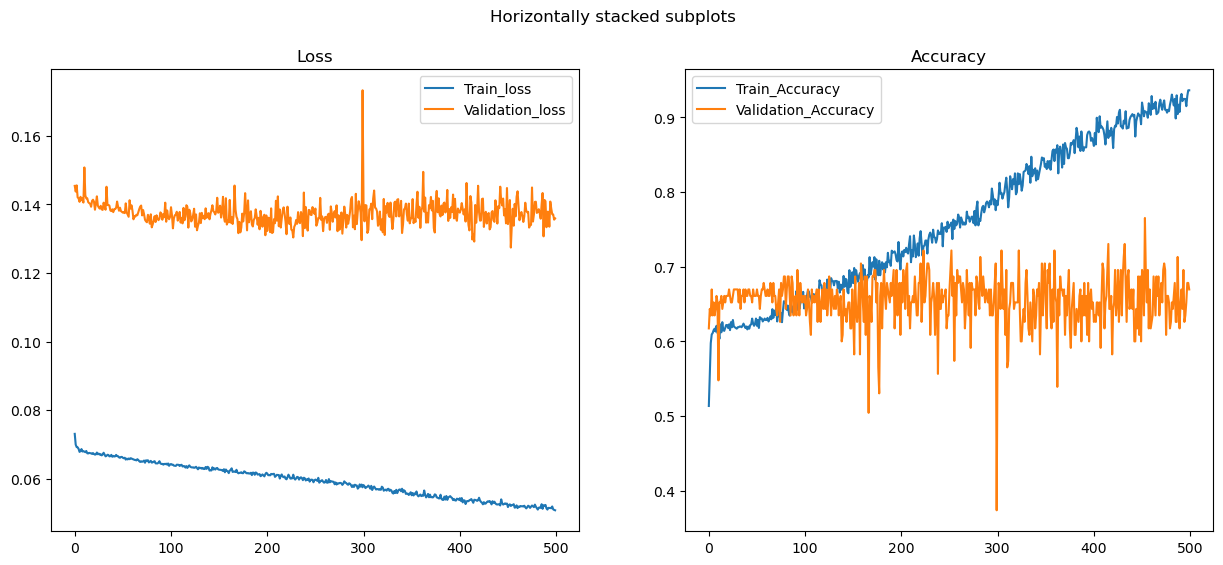

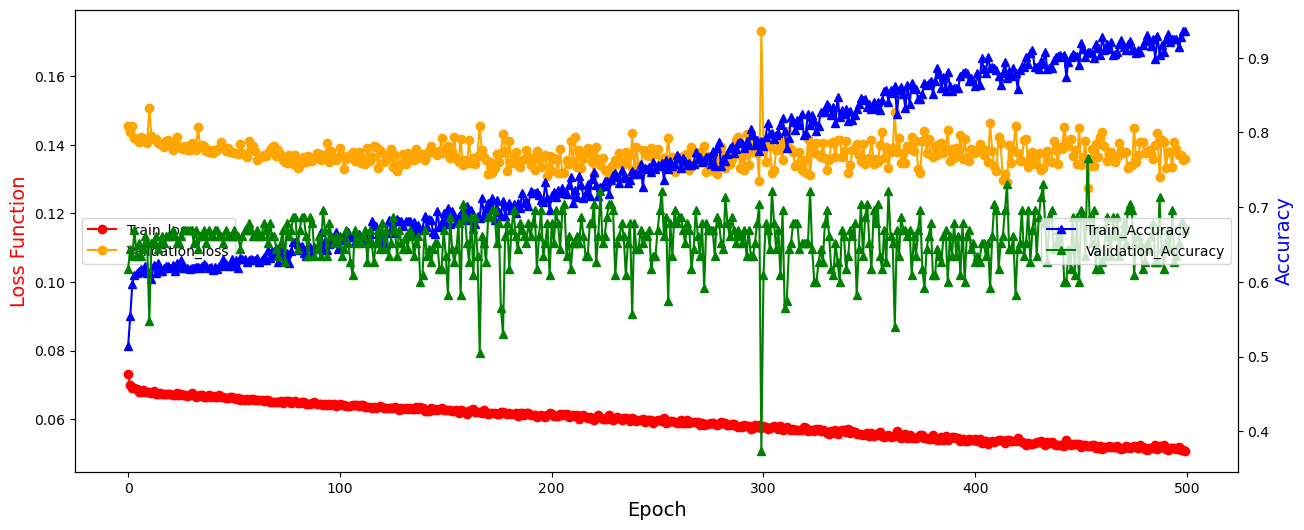

Current time: 158.894 minutes. Time expected till completion: 0.000 minutes
Finished training in: 158.895 minutes


In [15]:
#loader = train_loader # Use the train loader to train
#loader2 = valid_loader
# Main
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

val_loss_withDataAug, val_accuracy_withDataAug = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # in pytorch you have assign the zero for gradien in any sub epoch
        #optim.zero_grad()
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()#################
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate accuracy
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total

    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)

    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

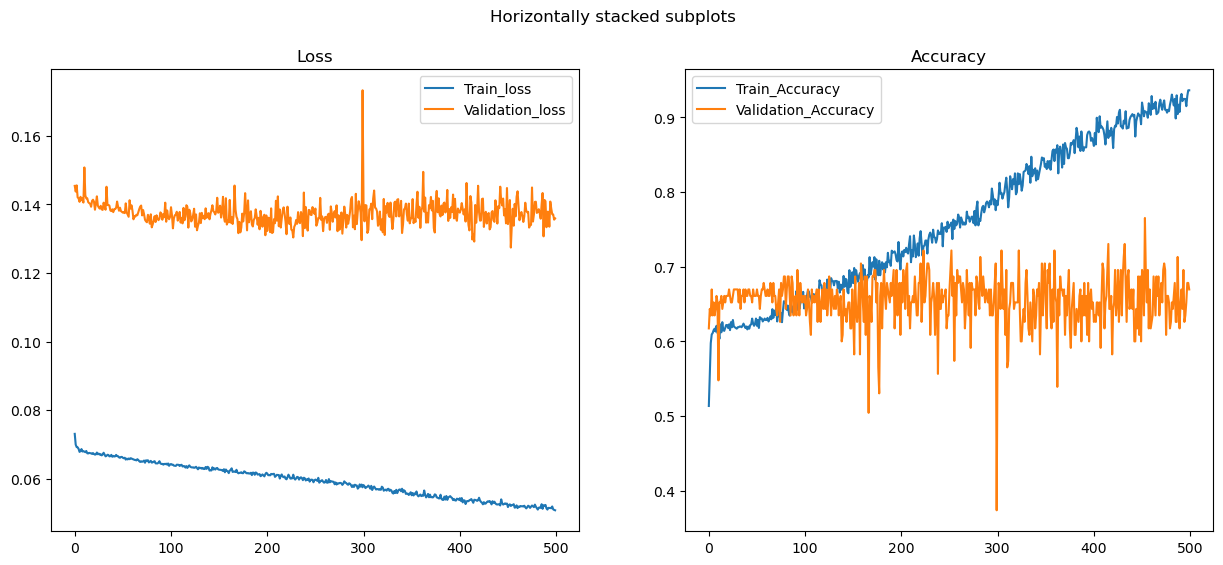

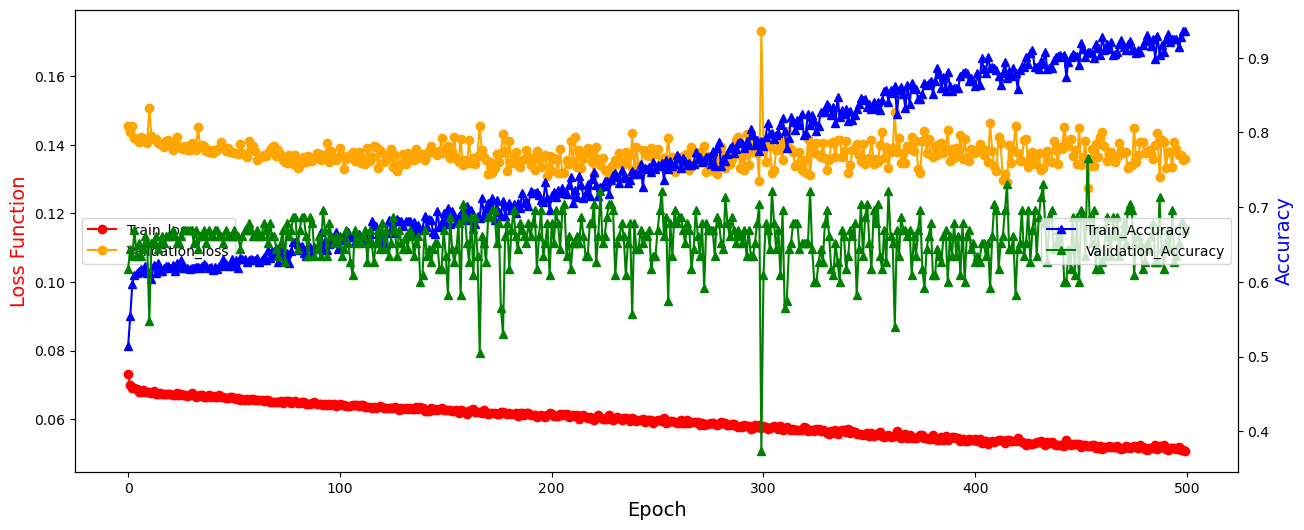

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### Save Model

In [17]:
torch.save(modelpy.state_dict(), model_checkpoints + "saved_model_state_dict.pt")
torch.save(modelpy, model_checkpoints + "saved_model.pt")

# 3. Evaluate your model using the developed software

In [18]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

Accuracy of the network on the 1034 Train instances: 92.35976789168278%
Accuracy of the network on the 115 Validation instances: 66.95652173913044%


In [19]:
# Import the test dataset
size_of_resized_img = (224,224) 
test_data, test_names = import_test_folder_dataset_2(test_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_names.shape)

Dim of Data:  (380, 224, 224, 3)
Dim of Lables:  (380,)


In [20]:
# Create the dataset object
test_Dataset = Data_test_2(test_data, test_names, img_transform_val)#img_transform_val
print("Test len: ",len(test_Dataset))

Test len:  380


In [21]:
# Make the predictions for the test dataset
predictions_list, names = make_predictions(modelpy=modelpy, dataset=test_Dataset, device=device)
len(predictions_list)

380

In [22]:
# Save the Predictions
save_predictions_as_csv(names=names, predictions=predictions_list, name="06_8Conv_0Res_128FChannels_4Batch.csv")

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points